# RESNETXINCEPTION MODEL

Class Names: ['Appropriate', 'Inappropriate']
Appropriate class size: 802
Inappropriate class size: 804


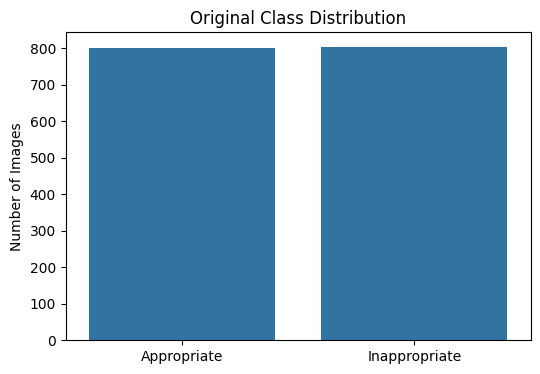

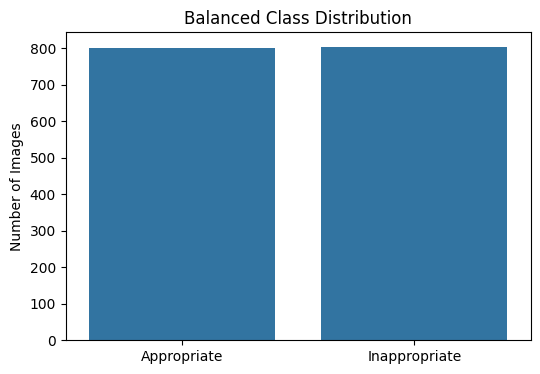

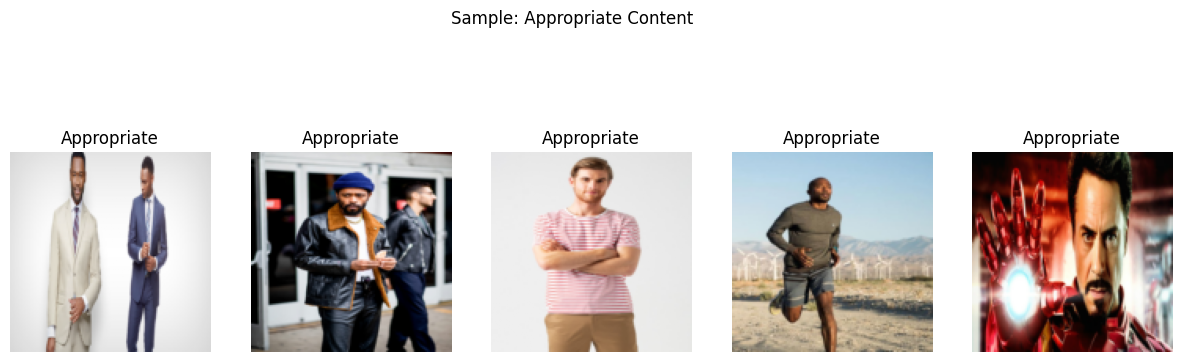

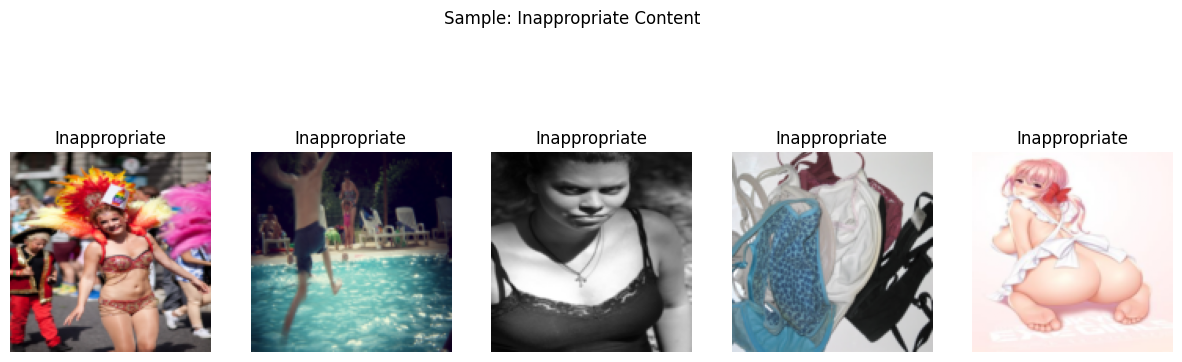

BEFORE Train set size: 1124
BEFORE Train set size: 1124
Train set size: 2248
Validation set size: 240
Test set size: 242
Train set size: 2248
Validation set size: 240
Test set size: 242
Balanced class distribution: 802 appropriate, 804 inappropriate


E:\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [1]:

import torch
import csv
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import InterpolationMode
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset,  Subset, random_split
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torchvision import models
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import os
import seaborn as sns
import random
import torchvision.transforms.functional as F
from PIL import Image
from Datapreprocess import Applytransform_inception, Applytransform_resnet, AugmentedImageFolder_inception, AugmentedImageFolder_resnet


from sklearn.utils import shuffle


# Dataset path
dataset_path = "./train_800"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Directory not found: {dataset_path}")

transform_visual = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize for display
    transforms.ToTensor()
])




class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_size = max(w, h)
        pad_w = (max_size - w) // 2
        pad_h = (max_size - h) // 2
        return F.pad(image, (pad_w, pad_h, max_size - w - pad_w, max_size - h - pad_h), fill=0)
    
# Define transformations
transform_resnet = transforms.Compose([
    # transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_inception = transforms.Compose([
    # transforms.Resize((299, 299), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Define transformations
transform_interp1 = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_interp2 = transforms.Compose([
    transforms.Resize((299, 299), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load dataset with ResNet transformation (for balancing)
# dataset_resnet = ImageFolder(dataset_path, transform=transform_resnet)
dataset = ImageFolder(dataset_path)
dataset_resnet = ImageFolder(dataset_path)
dataset_visual = ImageFolder(dataset_path, transform=transform_visual)  # For showing images

# Extract class names
class_names = dataset_resnet.classes
print(f"Class Names: {class_names}")
# Separate images by class
appropriate_indices = [i for i, (_, label) in enumerate(dataset_resnet.imgs) if label == 0]
inappropriate_indices = [i for i, (_, label) in enumerate(dataset_resnet.imgs) if label == 1]

# Check class sizes
print(f"Appropriate class size: {len(appropriate_indices)}")
print(f"Inappropriate class size: {len(inappropriate_indices)}")

# 🔹 **Plot original class distribution**
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Original Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# Undersample the larger class
if len(appropriate_indices) > len(inappropriate_indices):
    appropriate_indices = random.sample(appropriate_indices, len(inappropriate_indices))

# Merge the balanced indices and shuffle
balanced_indices = appropriate_indices + inappropriate_indices
balanced_indices = shuffle(balanced_indices)

# 🔹 **Plot balanced class distribution**
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Balanced Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# Sample and show images from both classes
def show_images(indices, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, idx in enumerate(random.sample(indices, num_images)):
        img, label = dataset_visual[idx]
        axes[i].imshow(img.permute(1, 2, 0))  # Convert to (H, W, C)
        axes[i].set_title(class_names[label])
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

# 🔹 **Display sample images**
show_images(appropriate_indices, "Sample: Appropriate Content")
show_images(inappropriate_indices, "Sample: Inappropriate Content")
# Create balanced datasets
### BALANCED DATASET RESNET AND INCEPTION VARIABLES ARE NOT USED SO I COMMENTED THEM OUT
# balanced_dataset_resnet = Subset(dataset_resnet, balanced_indices)
dataset_inception = ImageFolder(dataset_path)
# balanced_dataset_inception = Subset(dataset_inception, balanced_indices)

# # Train-test split
# train_idx, val_idx = train_test_split(balanced_indices, test_size=0.2, random_state=42)

# train_resnet = Subset(dataset_resnet, train_idx)
# val_resnet = Subset(dataset_resnet, val_idx)

# train_inception = Subset(dataset_inception, train_idx)
# val_inception = Subset(dataset_inception, val_idx)

# # Data Loaders
# train_loader_resnet = DataLoader(train_resnet, batch_size=32, shuffle=True)
# val_loader_resnet = DataLoader(val_resnet, batch_size=32, shuffle=False)

# train_loader_inception = DataLoader(train_inception, batch_size=32, shuffle=True)
# val_loader_inception = DataLoader(val_inception, batch_size=32, shuffle=False)




# Define split sizes (e.g., 70% train, 15% val, 15% test)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure total length matches

# train_idx, val_idx, test_idx = random_split(dataset_inception, [train_size, val_size, test_size])

# Split indices
train_idx = balanced_indices[:train_size]
val_idx = balanced_indices[train_size:train_size + val_size]
test_idx = balanced_indices[train_size + val_size:]

# Create subsets for ResNet
train_resnet = Subset(dataset, train_idx)
val_resnet = Subset(dataset, val_idx)
test_resnet = Subset(dataset, test_idx)


# Create subsets for Inception (using the same indices)
train_inception = Subset(dataset, train_idx)
val_inception = Subset(dataset, val_idx)
test_inception = Subset(dataset, test_idx)
print(f"BEFORE Train set size: {len(train_resnet)}")
print(f"BEFORE Train set size: {len(train_inception)}")


train_resnet = AugmentedImageFolder_resnet(train_resnet)
train_inception = AugmentedImageFolder_inception(train_inception)

# Apply transformations to val & test sets
val_resnet = Applytransform_resnet(val_resnet)
test_resnet = Applytransform_resnet(test_resnet)

val_inception = Applytransform_inception(val_inception)
test_inception = Applytransform_inception(test_inception)





train_loader_resnet = DataLoader(train_resnet, batch_size=32, shuffle=True)
val_loader_resnet = DataLoader(val_resnet, batch_size=32, shuffle=False)
test_loader_resnet = DataLoader(test_resnet, batch_size=32, shuffle=False)

train_loader_inception = DataLoader(train_inception, batch_size=32, shuffle=True)
val_loader_inception = DataLoader(val_inception, batch_size=32, shuffle=False)
test_loader_inception = DataLoader(test_inception, batch_size=32, shuffle=False)

print(f"Train set size: {len(train_resnet)}")
print(f"Validation set size: {len(val_resnet)}")
print(f"Test set size: {len(test_resnet)}")

print(f"Train set size: {len(train_inception)}")
print(f"Validation set size: {len(val_inception)}")
print(f"Test set size: {len(test_inception)}")




# Check class distribution in the balanced dataset
print(f"Balanced class distribution: {len(appropriate_indices)} appropriate, {len(inappropriate_indices)} inappropriate")

# Define the model
class FusionModel(nn.Module):
    def __init__(self, num_classes):
        super(FusionModel, self).__init__()
        
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.inception = models.inception_v3(aux_logits=False)
        pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        state_dict = pretrained_model.state_dict()
        self.inception.load_state_dict(state_dict, strict=False)
        
        # Step 1: Freeze All Layers Initially**
        for param in self.resnet.parameters():
            param.requires_grad = False
        for param in self.inception.parameters():
            param.requires_grad = False
        
        # for param in self.resnet.fc.parameters():
        #       param.requires_grad = True
        # for param in self.inception.fc.parameters():
        #       param.requires_grad = True    
              
        self.resnet.fc = nn.Identity()
        self.inception.fc = nn.Identity()
                   
        # self.resnet.fc = None
        # self.inception.fc = None
        
        self.batch_norm = nn.BatchNorm1d(4096)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(4096, 1)
        
    def forward(self, x_resnet, x_inception):
        resnet_features = self.resnet(x_resnet)
        inception_features = self.inception(x_inception)
        if isinstance(inception_features, tuple):  # InceptionV3 returns a tuple
            inception_features = inception_features[0]  # Take only the main output
        fused_features = torch.cat((resnet_features, inception_features), dim=1)
        fused_features = self.batch_norm(fused_features)
        fused_features = self.relu(fused_features)
        fused_features = self.dropout(fused_features)
        output = torch.sigmoid(self.fc(fused_features))
        # output = self.fc(fused_features)  # No sigmoid here

        return output

# class FusionModel(nn.Module):
#     def __init__(self, num_classes):
#         super(FusionModel, self).__init__()

#         # Load pretrained ResNet50 and freeze all layers
#         self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#         for param in self.resnet.parameters():
#             param.requires_grad = False
#         self.resnet.fc = nn.Identity()  # Remove ResNet FC layer

#         # Load pretrained InceptionV3
#         self.inception = models.inception_v3(aux_logits=False)
#         pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
#         state_dict = pretrained_model.state_dict()
#         self.inception.load_state_dict(state_dict, strict=False)

#         # Freeze all Inception layers initially
#         for param in self.inception.parameters():
#             param.requires_grad = False

#         # Retain only high-level layers (6d, 6e, 7a, 7b, 7c) by unfreezing them
#         for layer in [self.inception.Mixed_6d, self.inception.Mixed_6e,
#                       self.inception.Mixed_7a, self.inception.Mixed_7b,
#                       self.inception.Mixed_7c]:
#             for param in layer.parameters():
#                 param.requires_grad = False

#         # Corrected preprocessing step to maintain 4D tensors through convolution layers
#         self.inception_preprocess = nn.Sequential(
#             pretrained_model.Conv2d_1a_3x3,
#             pretrained_model.Conv2d_2a_3x3,
#             pretrained_model.Conv2d_2b_3x3,
#             pretrained_model.maxpool1,
#             pretrained_model.Conv2d_3b_1x1,
#             pretrained_model.Conv2d_4a_3x3,
#             pretrained_model.maxpool2,
#             pretrained_model.Mixed_5b,
#             pretrained_model.Mixed_5c,
#             pretrained_model.Mixed_5d,
#             pretrained_model.Mixed_6a,
#             pretrained_model.Mixed_6b,
#             pretrained_model.Mixed_6c
#         )
#         for param in self.inception_preprocess.parameters():
#             param.requires_grad = False


#         # Adjust Inception forward path without flattening prematurely
#         self.inception_forward = nn.Sequential(
#             self.inception.Mixed_6d,
#             self.inception.Mixed_6e,
#             self.inception.Mixed_7a,
#             self.inception.Mixed_7b,
#             self.inception.Mixed_7c,
#             nn.AdaptiveAvgPool2d((1, 1)),
#             # nn.Flatten()
#         )

#         self.inception.fc = nn.Identity()  # Remove Inception FC layer

#         # Fusion head after concatenation
#         self.batch_norm = nn.BatchNorm1d(4096)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.4)
#         self.fc = nn.Linear(4096, num_classes)

#     def forward(self, x_resnet, x_inception):
#         # ResNet50 features
#         resnet_features = self.resnet(x_resnet)

#         # Preprocess and extract high-level Inception features while maintaining 4D shape
#         x_inception = self.inception_preprocess(x_inception)
#         inception_features = self.inception_forward(x_inception)
#         if isinstance(inception_features, tuple):
#             inception_features = inception_features[0]  # Handle tuple output if any

#         # Concatenate ResNet and Inception features
#         fused_features = torch.cat((resnet_features, inception_features), dim=1)
#         fused_features = self.batch_norm(fused_features)
#         fused_features = self.relu(fused_features)
#         fused_features = self.dropout(fused_features)
#         output = self.fc(fused_features)  # No sigmoid here

#         return output


    
# Initialize model
model = FusionModel(num_classes=1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()  # Use this instead of BCELoss() para may SIGMOID ACTIVATION INSIDE
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

### original size


In [4]:
import random
from PIL import Image

# Check a few random images from the dataset
num_samples = 1
indices = random.sample(range(len(train_loader_inception)), num_samples)

for idx in indices:
    img_path, label = dataset_inception.samples[idx]  # Get image file path
    img = Image.open(img_path)
    # print(img.shape)
    print(img.size)

    print(f"Image {idx}: Mode = {img.mode}, Path = {img_path}")


(300, 478)
Image 0: Mode = RGB, Path = ./train_45\Appropriate\00000018.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the 

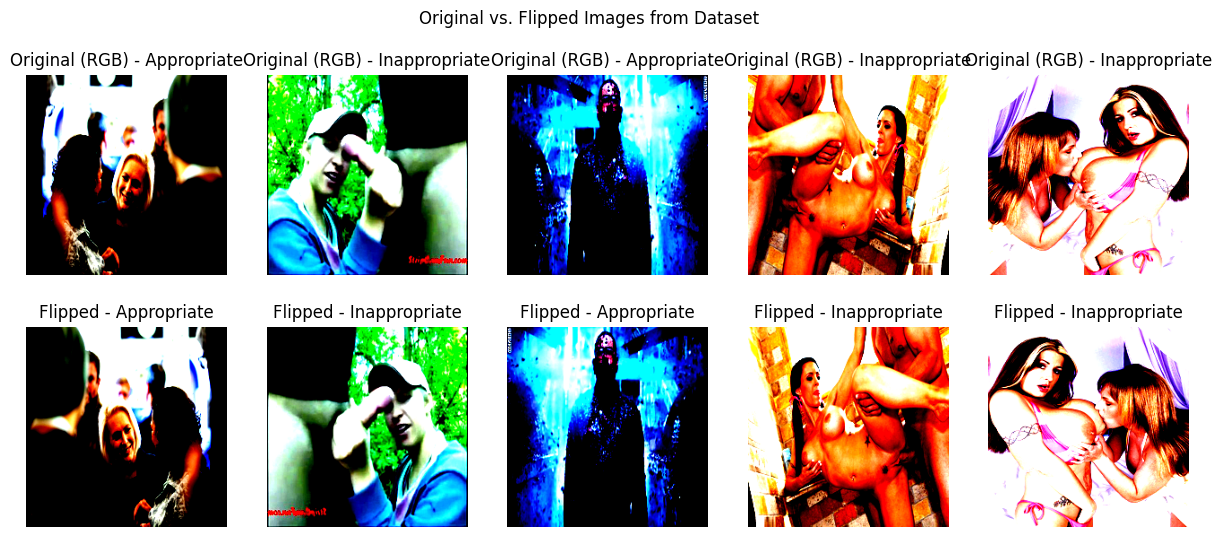

In [5]:
import matplotlib.pyplot as plt
import torch
import random
from PIL import Image
from torchvision import transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display original vs. augmented (flipped) images
def show_original_vs_augmented(train_dataset, raw_dataset, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        index = random.randint(0, len(train_dataset) // 2 - 1)  # Select original images only
        original_idx = index * 2  # Original image index
        flipped_idx = original_idx + 1  # Flipped image index

        # Get original file path (before transformation)
        img_path, label_original = raw_dataset.samples[index]

        # Open original image with PIL
        img_pil = Image.open(img_path)
        mode_original = img_pil.mode  # Check mode

        # ✅ Check if image is in RGB mode
        if mode_original != "RGB":
            print(f"Warning: Image {img_path} is in {mode_original} mode. Converting to RGB.")
            img_pil = img_pil.convert("RGB")

        # Load images from train_dataset (already transformed)
        img_original, label_original = train_dataset[original_idx]
        img_flipped, label_flipped = train_dataset[flipped_idx]

        # Move tensors to CPU before converting to numpy
        img_original_np = img_original.cpu().permute(1, 2, 0).numpy()
        img_flipped_np = img_flipped.cpu().permute(1, 2, 0).numpy()

        # Display original
        axes[0, i].imshow(img_original_np)
        axes[0, i].set_title(f"Original ({mode_original}) - {raw_dataset.classes[label_original]}")
        axes[0, i].axis("off")

        # Display flipped
        axes[1, i].imshow(img_flipped_np)
        axes[1, i].set_title(f"Flipped - {raw_dataset.classes[label_flipped]}")
        axes[1, i].axis("off")

    plt.suptitle("Original vs. Flipped Images from Dataset")
    plt.show()

# Call function using the correct variables
show_original_vs_augmented(train_resnet, dataset)


### transformed size

In [13]:
import torch
import random
from PIL import Image

def check_image_sizes(images, num_images=5):
    """
    Check the sizes of a few randomly selected images from the train_dataset.
    This function assumes that the images in train_dataset are tensors.
    """
    for i in range(num_images):
        # Randomly select an index from the dataset
        idx = random.randint(0, len(images) - 1)
        img_tensor, label = images[idx]
        
        # Ensure the tensor is on the CPU
        img_tensor = img_tensor.cpu()
        
        # Get the image shape: (Channels, Height, Width)
        channels, height, width = img_tensor.shape
        
        print(f"Image {i+1} (Index {idx}): Channels={channels}, Height={height}, Width={width}")

# Example usage:
check_image_sizes(train_inception, num_images=5)


Image 1 (Index 85): Channels=3, Height=299, Width=299
Image 2 (Index 23): Channels=3, Height=299, Width=299
Image 3 (Index 10): Channels=3, Height=299, Width=299
Image 4 (Index 100): Channels=3, Height=299, Width=299
Image 5 (Index 117): Channels=3, Height=299, Width=299


Original Image Size: (852, 1280)
Transformed Image Size: torch.Size([3, 299, 299])


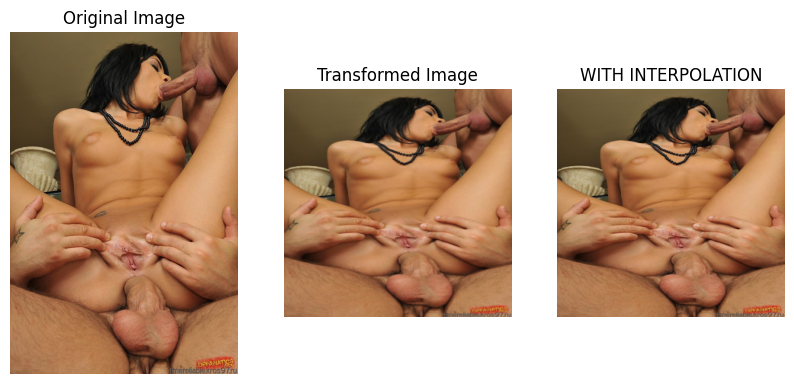

Original Image Size: (661, 1024)
Transformed Image Size: torch.Size([3, 224, 224])


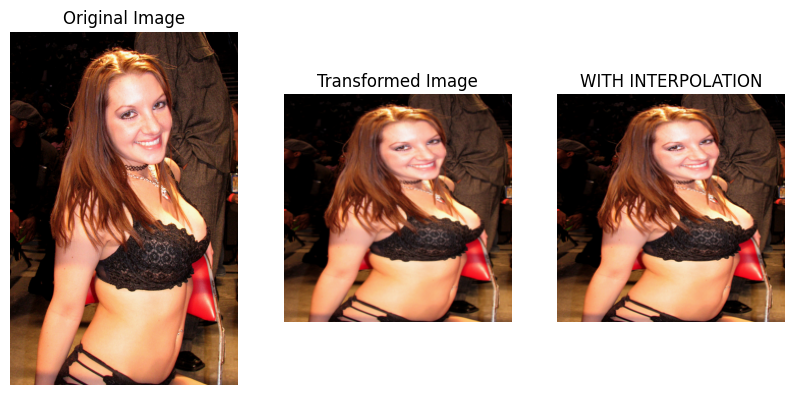

In [14]:
# Load a sample image from the dataset
img_path, _ = dataset.samples[54]  # Get the path of the first image
original_img = Image.open(img_path)

# Apply transformation
transformed_img, _ = dataset_inception[54]  # Dataset returns (image, label)


original_img = Image.open(img_path)  # Open image with PIL


transformed = transform_inception(original_img)  # Apply resizing
transformed2 = transform_interp2(original_img)  # Apply resizing

# Print image sizes
print("Original Image Size:", original_img.size)  # (width, height)
print("Transformed Image Size:", transformed2.shape)  # (channels, height, width)


# Convert transformed tensor back to an image for visualization (unnormalize)
unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
    std=[1/0.229, 1/0.224, 1/0.225]
)
img_un = unnormalize(transformed)  # Reverse normalization
img_un = torch.clamp(img_un, 0, 1)  # Ensure values

# Convert tensor to numpy format for display
img_un = img_un.permute(1, 2, 0).numpy()  # (H, W, C)



img_un2 = unnormalize(transformed2)  # Reverse normalization
img_un2 = torch.clamp(img_un2, 0, 1)  # Ensure values

# Convert tensor to numpy format for display
img_un2 = img_un2.permute(1, 2, 0).numpy()  # (H, W, C)


# Plot original and transformed images
plt.figure(figsize=(10, 5))

# Original image
# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

# Transformed image (resized + normalized)
plt.subplot(1, 3, 2)
plt.imshow(img_un)
plt.title("Transformed Image")
plt.axis("off")

# Transformed image (resized + normalized)
plt.subplot(1, 3, 3)
plt.imshow(img_un2)
plt.title("WITH INTERPOLATION")
plt.axis("off")

plt.show()





# Load a sample image from the dataset
img_path2, _ = dataset.samples[50]  
original_img = Image.open(img_path2)

transformed_img, _ = dataset_resnet[50] 



original_img = Image.open(img_path2)  # Open image with PIL


transformed = transform_resnet(original_img)  # Apply resizing
transformed2 = transform_interp1(original_img)  # Apply resizing

print("Original Image Size:", original_img.size) 
print("Transformed Image Size:", transformed2.shape) 


# Convert transformed tensor back to an image for visualization (unnormalize)
unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
    std=[1/0.229, 1/0.224, 1/0.225]
)
img_un = unnormalize(transformed)  # Reverse normalization
img_un = torch.clamp(img_un, 0, 1)  # Ensure values

# Convert tensor to numpy format for display
img_un = img_un.permute(1, 2, 0).numpy()  # (H, W, C)


img_un2 = unnormalize(transformed2)  # Reverse normalization
img_un2 = torch.clamp(img_un2, 0, 1)  # Ensure values

# Convert tensor to numpy format for display
img_un2 = img_un2.permute(1, 2, 0).numpy()  # (H, W, C)

# Plot original and transformed images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

# Transformed image (resized + normalized)
plt.subplot(1, 3, 2)
plt.imshow(img_un)
plt.title("Transformed Image")
plt.axis("off")

# Transformed image (resized + normalized)
plt.subplot(1, 3, 3)
plt.imshow(img_un2)
plt.title("WITH INTERPOLATION")
plt.axis("off")


plt.show()







### model summary

In [8]:
from torchinfo import summary
from torchvision.models import inception_v3


torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
print(model)
# summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])

for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

FusionModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

### Plots

In [2]:
    
def plot_from_history(history):
    # Extract data from history
    epochs = history["epoch"]
    train_losses = history["train_loss"]
    val_losses = history["val_loss"]
    train_accuracies = history["train_accuracy"]
    val_accuracies = history["val_accuracy"]

    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue", marker='o')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # plt.savefig('training_history.png')  # PNG image
    plt.show()
  
def plot_roc_curve(metrics):
    auc_score = metrics['auc_roc'][0]
  
    roc_fpr = list(map(float, metrics['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics['roc_curve_tpr'][0].split(', ')))
    # Plot ROC Curve
    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


## First Training

In [6]:
# Training loop
def train_model(model, train_loader_resnet, train_loader_inception, val_loader_resnet, val_loader_inception, 
                criterion, optimizer, epochs=5,scheduler=None):
   
    
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
    "epoch": [],
    "class_names": [],
    "confusion_matrix": [],
    "accuracy": [],
    "fpr": [],
    "fnr": [],
    "auc_roc": [],
    "roc_curve_fpr": [],
    "roc_curve_tpr": []
}

       
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Use tqdm on the zip object directly
        progress_bar = tqdm(zip(train_loader_resnet, train_loader_inception), 
                             total=len(train_loader_resnet), 
                             desc=f"Epoch {epoch+1}/{epochs}")

        for (resnet_batch, inception_batch) in progress_bar:
            x_resnet, y = resnet_batch
            x_inception, _ = inception_batch
            
            # Move data to the appropriate device
            x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

            optimizer.zero_grad()
            outputs = model(x_resnet, x_inception).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = (outputs > 0.5).float()  # ✅ Logits threshold at 0 (not 0.5 since no sigmoid in forward)          
            correct += (preds == y).sum().item()
            total += y.size(0)

            # Update progress bar with loss and accuracy
            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)
            

        epoch_loss = running_loss / len(train_loader_resnet)
        epoch_acc = 100 * correct / total
       
        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for (resnet_batch, inception_batch) in zip(val_loader_resnet, val_loader_inception):
                x_resnet, y = resnet_batch
                x_inception, _ = inception_batch
                x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

                outputs = model(x_resnet, x_inception).squeeze()
                loss = criterion(outputs, y)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()  # ✅ Logits threshold at 0 (not 0.5 since no sigmoid in forward)                
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)
                
                
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())


        val_loss /= len(val_loader_resnet)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0
        
        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")
        
        # Store metrics
       
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
     

        model.train()  # Return model to training mode
        if scheduler:
                # scheduler.step(val_loss)
                print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
                scheduler.step()
                print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

            # scheduler.step()  

    print("Training complete")
   
    # Compute Additional Metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    print("\nAdditional Metrics:") 
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")  # Explicit print
    # Save Additional Metrics
  # Update metrics dictionary for the current epoch (replace `epoch_number` with actual epoch)
    metrics["class_names"].append(class_names)
    metrics["confusion_matrix"].append(conf_matrix.ravel())  # Flatten confusion matrix to a list
    metrics["fpr"].append(fpr)
    metrics["fnr"].append(fnr)
    metrics["auc_roc"].append(auc_score)
    metrics["roc_curve_fpr"].append(fpr_vals)
    metrics["roc_curve_tpr"].append(tpr_vals)
   
    return history, metrics  # Return history dictionary for immediate plotting if needed


In [ ]:


history, metrics = train_model(model, train_loader_resnet, train_loader_inception, 
                      val_loader_resnet, val_loader_inception, 
                      criterion, optimizer, epochs=5 )

# # Evaluation
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for (resnet_batch, inception_batch) in zip(test_loader_resnet, test_loader_inception):
        x_resnet, y = resnet_batch
        x_inception, _ = inception_batch
        x_resnet, x_inception, y = x_resnet.to("cuda"), x_inception.to("cuda"), y.to("cuda").float()
        outputs = model(x_resnet, x_inception).squeeze()
        # preds = (outputs > 0.5).cpu().numpy()
        # y_true.extend(y.cpu().numpy())
        # y_pred.extend(preds)
        # Convert probabilities to binary predictions
        preds = (outputs > 0.5).cpu().int().numpy()

        # Store ground-truth labels and predictions
        y_true.extend(y.cpu().int().numpy())
        y_pred.extend(preds)
        y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC
        
# print(classification_report(y_true, y_pred))
# print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")

# Generate classification report
# report = classification_report(y_true, y_pred)


# Compute Additional Metrics for Test Set
conf_matrix = confusion_matrix(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_prob)
fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
tn, fp, fn, tp = conf_matrix.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Print Test Metrics
print("\nTest Set Metrics:")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")




report = classification_report(y_true, y_pred, target_names=["Appropriate", "Inappropriate"])

# Save classification report to a file
# with open("training_history/first_classification_reportv7.txt", "w") as file:
    
#     file.write(report + "\n")  # Write the classification report
#     file.write(f"Accuracy Score: {accuracy_score(y_true, y_pred)}\n") 
# Optionally, print to console as well

print(report)
print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")

In [7]:
with open("training_history/first_classification_reportv7.txt", "r") as file:
    report = file.read()

print(report)

               precision    recall  f1-score   support

  Appropriate       0.87      0.99      0.93       117
Inappropriate       0.99      0.86      0.92       125

     accuracy                           0.93       242
    macro avg       0.93      0.93      0.93       242
 weighted avg       0.93      0.93      0.93       242

Accuracy Score: 0.9256198347107438



save training history

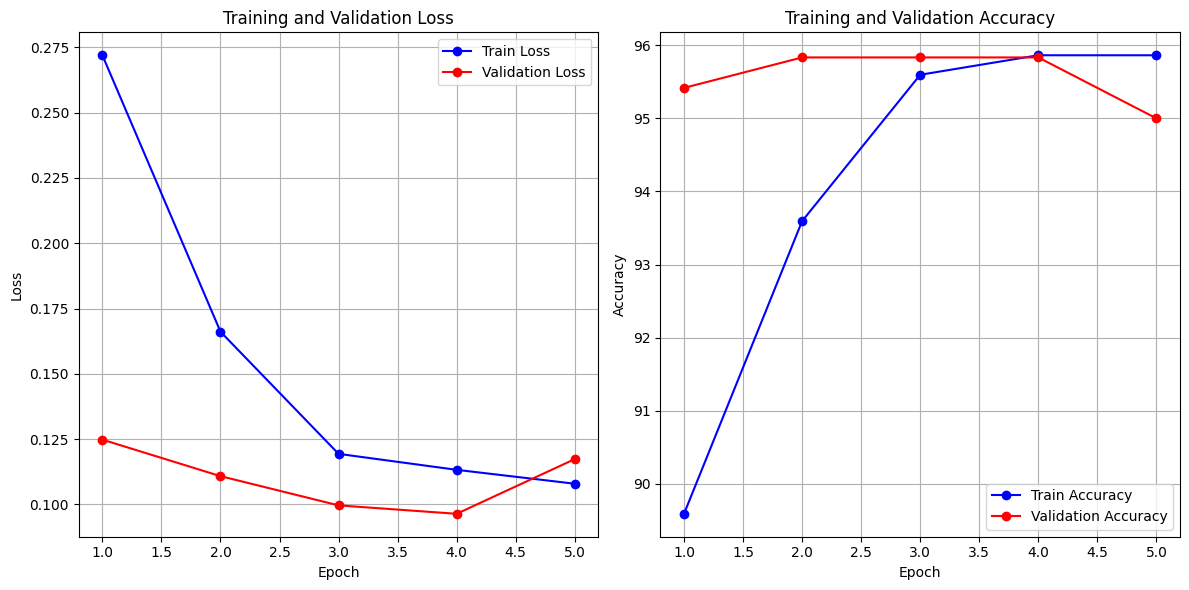

In [15]:
plot_from_history(history)

In [8]:
df = pd.DataFrame(history)
df.to_csv('training_history/first_training_historyv7.csv', index=False)

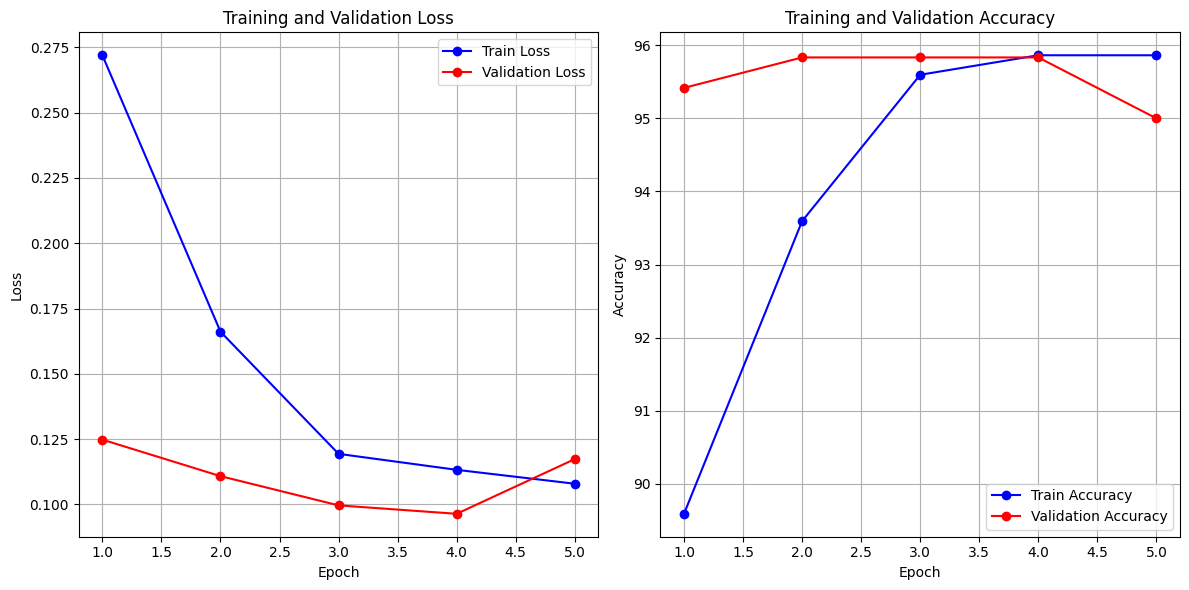

In [9]:
history_df = pd.read_csv('training_history/first_training_historyv7.csv')

history = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}

plot_from_history(history)

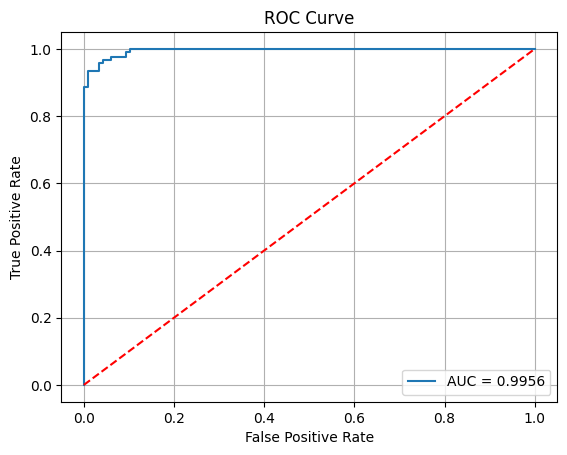

In [10]:
import pandas as pd

# Flatten data for CSV saving
metrics_flat = {
    "class_names": metrics["class_names"],
    "fpr": metrics["fpr"],
    "fnr": metrics["fnr"],
    "auc_roc": metrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in metrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in metrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in metrics["confusion_matrix"]]
}
plot_roc_curve(metrics_flat)


In [11]:
# Save metrics to CSV
metrics_df = pd.DataFrame(metrics_flat)

metrics_df.to_csv('training_history/first_training_metricsv7.csv', index=False)



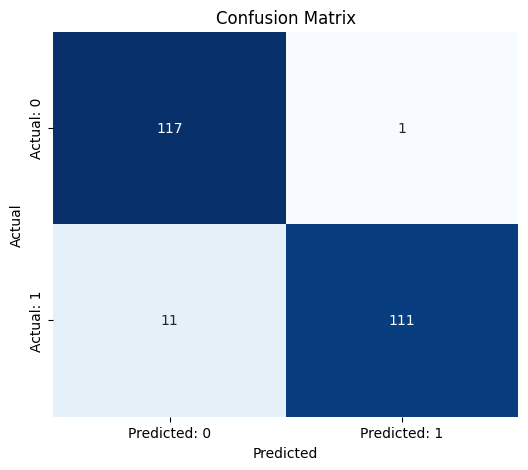

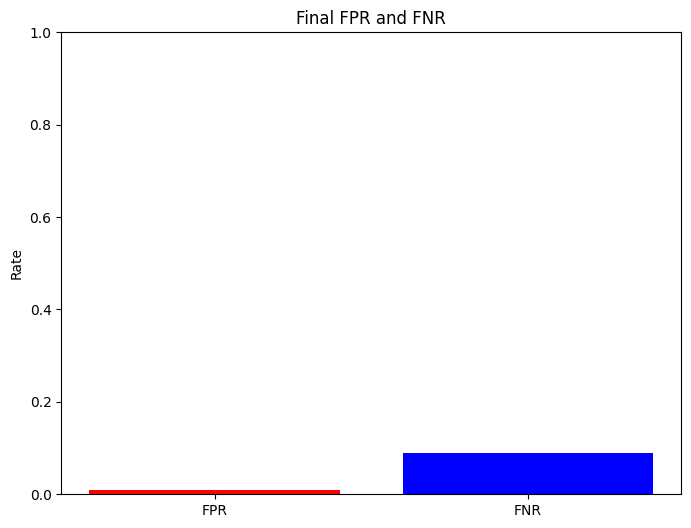

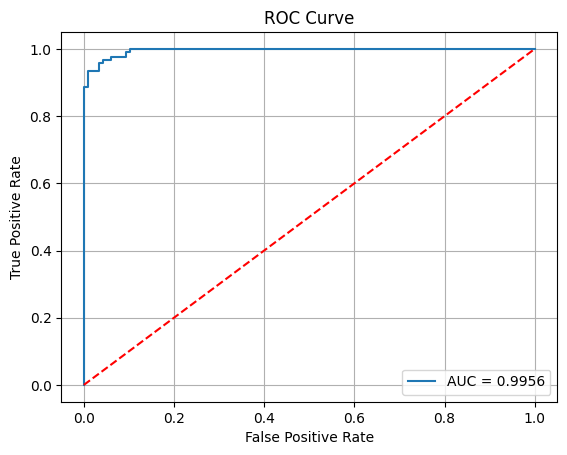

In [12]:


# Load the CSV file containing the final metrics
metrics_df = pd.read_csv('training_history/first_training_metricsv7.csv')

# Extract individual metrics
auc_score = metrics_df['auc_roc'][0]
fpr = metrics_df['fpr'][0]
fnr = metrics_df['fnr'][0]

# Extract confusion matrix (flattened form)
conf_matrix = list(map(int, metrics_df['confusion_matrix'][0].split(', ')))  # Convert string to list of integers
tn, fp, fn, tp = conf_matrix

# Extract ROC curve data (flattened form)
roc_fpr = list(map(float, metrics_df['roc_curve_fpr'][0].split(', ')))
roc_tpr = list(map(float, metrics_df['roc_curve_tpr'][0].split(', ')))
# Confusion Matrix heatmap
conf_matrix = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot FPR and FNR
plt.figure(figsize=(8, 6))
plt.bar(['FPR', 'FNR'], [fpr, fnr], color=['red', 'blue'])
plt.ylabel('Rate')
plt.title('Final FPR and FNR')
plt.ylim(0, 1)
plt.show()

plt.figure()
plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()


## Second Training - Unfreeze layers for fine tuning

In [4]:
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR

# Unfreeze the last 50 layers of Inception and the last 94 layers of ResNet
# for param in list(model.inception.parameters())[-132:]:
#     param.requires_grad = True
# for param in list(model.resnet.parameters())[-75:]:
#     param.requires_grad = True

 
for param in model.resnet.layer4.parameters():  # Unfreezing layer4 (last block)
    param.requires_grad = True
for param in model.resnet.layer3.parameters():  # Unfreezing layer4 (last block)
    param.requires_grad = True
# # Unfreezing the last few Inception blocks
for param in model.inception.Mixed_7c.parameters():
    param.requires_grad = True

for param in model.inception.Mixed_7b.parameters():
    param.requires_grad = True

for param in model.inception.Mixed_7a.parameters():
    param.requires_grad = True

for param in model.inception.Mixed_6e.parameters():
    param.requires_grad = True

for param in model.inception.Mixed_6d.parameters():
    param.requires_grad = True


# for layer in [model.inception.Mixed_6d, model.inception.Mixed_6e,
#               model.inception.Mixed_7a, model.inception.Mixed_7b,
#               model.inception.Mixed_7c]:
#     for param in layer.parameters():
#         param.requires_grad = True

# for param in model.inception_preprocess.parameters():
#     param.requires_grad = True









# # Reset optimizer with a lower learning rate
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

# torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
print(model)
# # summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])

for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


# Hyperparameter tuning example
# learning_rates = [0.0001, 0.0005]
# batch_sizes = [32, 64]
# best_accuracy = 0.0
# best_params = {}
# try:
#     for lr in learning_rates:
#         for batch_size in batch_sizes:
#             # Set optimizer
#             optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

#             # Set DataLoader
#             train_loader_resnet = DataLoader(train_resnet, batch_size=batch_size, shuffle=True)
#             train_loader_inception = DataLoader(train_inception, batch_size=batch_size, shuffle=True)

#             # Training loop with scheduler
#             scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

#             # Train the model
#             secondhistory, secondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
#                                                     val_loader_resnet, val_loader_inception, 
#                                                     criterion, optimizer, epochs=5)

#             # Check performance
#             average_accuracy = sum(secondhistory['val_accuracy']) / len(secondhistory['val_accuracy'])
#             if average_accuracy > best_accuracy:
#                 best_accuracy = average_accuracy
#                 best_params = {'lr': lr, 'batch_size': batch_size}

#             scheduler.step()
# except Exception as e:
#     print(f"Error occurred: {e}, but training will continue with the next parameters.")
    
# print(f"Best Hyperparameters: {best_params}, Best Accuracy: {best_accuracy}")

FusionModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

### PARAM TUNING WITH DECAYING LR


In [13]:
# Define hyperparameter search space
learning_rates = [0.0005 , 0.0009]
batch_sizes = [32, 64]
best_accuracy = 0.0
best_params = {}


for lr in learning_rates:
    for batch_size in batch_sizes:
            # Set optimizer
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

            # Set DataLoaders
            train_loader_resnet = DataLoader(train_resnet, batch_size=batch_size, shuffle=True)
            train_loader_inception = DataLoader(train_inception, batch_size=batch_size, shuffle=True)

            # Use CosineAnnealingLR
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00001)
            # Train the model
            secondhistory, secondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
                                                       val_loader_resnet, val_loader_inception, 
                                                       criterion, optimizer, epochs=5, scheduler=scheduler)

            # Check performance
            average_accuracy = sum(secondhistory['val_accuracy']) / len(secondhistory['val_accuracy'])

            if average_accuracy > best_accuracy:
                best_accuracy = average_accuracy
                best_params = {'lr': lr, 'batch_size': batch_size}



print(f"Best Hyperparameters: {best_params}, Best Accuracy: {best_accuracy}")


Epoch 1/5: 100%|██████████| 519/519 [15:06<00:00,  1.75s/it, accuracy=49.9, loss=58.3]



Epoch 1/5: Train Loss = 50.0674, Train Accuracy = 49.89%
Validation Loss = 49.3077, Validation Accuracy = 50.65%

Before Step Learning Rate: 0.0005
Current Learning Rate: 0.00045320916362186214


Epoch 2/5: 100%|██████████| 519/519 [14:30<00:00,  1.68s/it, accuracy=82.9, loss=0.199]



Epoch 2/5: Train Loss = 0.4463, Train Accuracy = 82.95%
Validation Loss = 0.2575, Validation Accuracy = 89.39%

Before Step Learning Rate: 0.00045320916362186214
Current Learning Rate: 0.00033070916362186215


Epoch 3/5: 100%|██████████| 519/519 [13:16<00:00,  1.54s/it, accuracy=89.6, loss=1.31]  



Epoch 3/5: Train Loss = 0.2553, Train Accuracy = 89.58%
Validation Loss = 0.2046, Validation Accuracy = 91.51%

Before Step Learning Rate: 0.00033070916362186215
Current Learning Rate: 0.0001792908363781379


Epoch 4/5: 100%|██████████| 519/519 [12:54<00:00,  1.49s/it, accuracy=92.8, loss=0.143] 



Epoch 4/5: Train Loss = 0.1780, Train Accuracy = 92.80%
Validation Loss = 0.1885, Validation Accuracy = 92.09%

Before Step Learning Rate: 0.0001792908363781379
Current Learning Rate: 5.67908363781379e-05


Epoch 5/5: 100%|██████████| 519/519 [12:54<00:00,  1.49s/it, accuracy=96, loss=2.53]    



Epoch 5/5: Train Loss = 0.1075, Train Accuracy = 96.00%
Validation Loss = 0.1524, Validation Accuracy = 93.68%

Before Step Learning Rate: 5.67908363781379e-05
Current Learning Rate: 1e-05
Training complete

Additional Metrics:
False Positive Rate (FPR): 0.0909
False Negative Rate (FNR): 0.0347
AUC-ROC Score: 0.9882
TN: 1910, FP: 191, FN: 71, TP: 1976


Epoch 1/5: 100%|██████████| 260/260 [23:11<00:00,  5.35s/it, accuracy=95.2, loss=0.58]  



Epoch 1/5: Train Loss = 0.1299, Train Accuracy = 95.22%
Validation Loss = 0.3314, Validation Accuracy = 88.65%

Before Step Learning Rate: 0.0005
Current Learning Rate: 0.00045320916362186214


Epoch 2/5: 100%|██████████| 260/260 [24:41<00:00,  5.70s/it, accuracy=96.9, loss=0.414]  



Epoch 2/5: Train Loss = 0.0818, Train Accuracy = 96.92%
Validation Loss = 0.2408, Validation Accuracy = 92.33%

Before Step Learning Rate: 0.00045320916362186214
Current Learning Rate: 0.00033070916362186215


Epoch 3/5: 100%|██████████| 260/260 [24:33<00:00,  5.67s/it, accuracy=98.2, loss=0.00554]



Epoch 3/5: Train Loss = 0.0479, Train Accuracy = 98.22%
Validation Loss = 0.2561, Validation Accuracy = 93.97%

Before Step Learning Rate: 0.00033070916362186215
Current Learning Rate: 0.0001792908363781379


Epoch 4/5: 100%|██████████| 260/260 [24:25<00:00,  5.64s/it, accuracy=99.6, loss=0.000176]



Epoch 4/5: Train Loss = 0.0122, Train Accuracy = 99.64%
Validation Loss = 0.2002, Validation Accuracy = 94.41%

Before Step Learning Rate: 0.0001792908363781379
Current Learning Rate: 5.67908363781379e-05


Epoch 5/5: 100%|██████████| 260/260 [24:10<00:00,  5.58s/it, accuracy=99.8, loss=3.24e-5] 



Epoch 5/5: Train Loss = 0.0066, Train Accuracy = 99.82%
Validation Loss = 0.1602, Validation Accuracy = 94.91%

Before Step Learning Rate: 5.67908363781379e-05
Current Learning Rate: 1e-05
Training complete

Additional Metrics:
False Positive Rate (FPR): 0.0571
False Negative Rate (FNR): 0.0445
AUC-ROC Score: 0.9912
TN: 1981, FP: 120, FN: 91, TP: 1956


Epoch 1/5: 100%|██████████| 519/519 [12:30<00:00,  1.45s/it, accuracy=93.8, loss=0.0353]



Epoch 1/5: Train Loss = 0.1790, Train Accuracy = 93.78%
Validation Loss = 0.2458, Validation Accuracy = 91.13%

Before Step Learning Rate: 0.0009
Current Learning Rate: 0.0008150125624968516


Epoch 2/5: 100%|██████████| 519/519 [4:15:10<00:00, 29.50s/it, accuracy=95.3, loss=0.015]       



Epoch 2/5: Train Loss = 0.1472, Train Accuracy = 95.29%
Validation Loss = 0.2259, Validation Accuracy = 91.97%

Before Step Learning Rate: 0.0008150125624968516
Current Learning Rate: 0.0005925125624968515


Epoch 3/5: 100%|██████████| 519/519 [14:33<00:00,  1.68s/it, accuracy=97, loss=0.034]    



Epoch 3/5: Train Loss = 0.1032, Train Accuracy = 96.99%
Validation Loss = 0.2781, Validation Accuracy = 92.02%

Before Step Learning Rate: 0.0005925125624968515
Current Learning Rate: 0.0003174874375031484


Epoch 4/5: 100%|██████████| 519/519 [13:04<00:00,  1.51s/it, accuracy=98.8, loss=0.00203] 



Epoch 4/5: Train Loss = 0.0319, Train Accuracy = 98.82%
Validation Loss = 0.3505, Validation Accuracy = 91.80%

Before Step Learning Rate: 0.0003174874375031484
Current Learning Rate: 9.49874375031484e-05


Epoch 5/5: 100%|██████████| 519/519 [12:49<00:00,  1.48s/it, accuracy=99.6, loss=0.000661]



Epoch 5/5: Train Loss = 0.0126, Train Accuracy = 99.59%
Validation Loss = 0.1839, Validation Accuracy = 94.24%

Before Step Learning Rate: 9.49874375031484e-05
Current Learning Rate: 1e-05
Training complete

Additional Metrics:
False Positive Rate (FPR): 0.0809
False Negative Rate (FNR): 0.0337
AUC-ROC Score: 0.9904
TN: 1931, FP: 170, FN: 69, TP: 1978


Epoch 1/5: 100%|██████████| 260/260 [25:03<00:00,  5.78s/it, accuracy=98.3, loss=0.0811]  



Epoch 1/5: Train Loss = 0.0525, Train Accuracy = 98.25%
Validation Loss = 0.6643, Validation Accuracy = 91.80%

Before Step Learning Rate: 0.0009
Current Learning Rate: 0.0008150125624968516


Epoch 2/5: 100%|██████████| 260/260 [25:58<00:00,  5.99s/it, accuracy=98.2, loss=0.523]   



Epoch 2/5: Train Loss = 0.0546, Train Accuracy = 98.23%
Validation Loss = 0.4270, Validation Accuracy = 92.36%

Before Step Learning Rate: 0.0008150125624968516
Current Learning Rate: 0.0005925125624968515


Epoch 3/5: 100%|██████████| 260/260 [26:39<00:00,  6.15s/it, accuracy=99.3, loss=0.000338]



Epoch 3/5: Train Loss = 0.0203, Train Accuracy = 99.30%
Validation Loss = 0.2748, Validation Accuracy = 93.37%

Before Step Learning Rate: 0.0005925125624968515
Current Learning Rate: 0.0003174874375031484


Epoch 4/5: 100%|██████████| 260/260 [25:09<00:00,  5.81s/it, accuracy=99.7, loss=6.46e-6] 



Epoch 4/5: Train Loss = 0.0118, Train Accuracy = 99.72%
Validation Loss = 0.2534, Validation Accuracy = 94.58%

Before Step Learning Rate: 0.0003174874375031484
Current Learning Rate: 9.49874375031484e-05


Epoch 5/5: 100%|██████████| 260/260 [25:20<00:00,  5.85s/it, accuracy=99.9, loss=0.00158] 



Epoch 5/5: Train Loss = 0.0034, Train Accuracy = 99.90%
Validation Loss = 0.2394, Validation Accuracy = 95.25%

Before Step Learning Rate: 9.49874375031484e-05
Current Learning Rate: 1e-05
Training complete

Additional Metrics:
False Positive Rate (FPR): 0.0438
False Negative Rate (FNR): 0.0513
AUC-ROC Score: 0.9901
TN: 2009, FP: 92, FN: 105, TP: 1942
Best Hyperparameters: {'lr': 0.0009, 'batch_size': 64}, Best Accuracy: 93.47155255544843


In [14]:
# Extract best hyperparameters
best_lr = best_params['lr']
best_batch_size = best_params['batch_size']

# Print to verify
print(f"Using Best Hyperparameters -> Learning Rate: {best_lr}, Batch Size: {best_batch_size}")

Using Best Hyperparameters -> Learning Rate: 0.0009, Batch Size: 64


## final Training

In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
train_loader_resnet = DataLoader(train_resnet, batch_size=64, shuffle=True)
train_loader_inception = DataLoader(train_inception, batch_size=64, shuffle=True)

Fsecondhistory, Fsecondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
                                                       val_loader_resnet, val_loader_inception, 
                                                       criterion, optimizer, epochs=5)

Epoch 1/5: 100%|██████████| 36/36 [04:34<00:00,  7.62s/it, accuracy=93.3, loss=0.0064]



Epoch 1/5: Train Loss = 0.1797, Train Accuracy = 93.28%
Validation Loss = 0.1197, Validation Accuracy = 95.42%



Epoch 2/5: 100%|██████████| 36/36 [04:31<00:00,  7.54s/it, accuracy=99.7, loss=0.0138] 



Epoch 2/5: Train Loss = 0.0191, Train Accuracy = 99.69%
Validation Loss = 0.0983, Validation Accuracy = 96.25%



Epoch 3/5: 100%|██████████| 36/36 [04:46<00:00,  7.97s/it, accuracy=99.7, loss=0.0194] 



Epoch 3/5: Train Loss = 0.0137, Train Accuracy = 99.69%
Validation Loss = 0.1015, Validation Accuracy = 96.25%



Epoch 4/5:  33%|███▎      | 12/36 [01:33<03:16,  8.20s/it, accuracy=100, loss=0.00444]

In [7]:

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00025)

            # Set DataLoaders
train_loader_resnet = DataLoader(train_resnet, batch_size=32, shuffle=True)
train_loader_inception = DataLoader(train_inception, batch_size=32, shuffle=True)

            # Use CosineAnnealingLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00009)
            # Train the model
Fsecondhistory, Fsecondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
                                                       val_loader_resnet, val_loader_inception, 
                                                       criterion, optimizer, epochs=5, scheduler=scheduler)

Epoch 1/5: 100%|██████████| 71/71 [01:41<00:00,  1.43s/it, accuracy=95.2, loss=0.12]   



Epoch 1/5: Train Loss = 0.1379, Train Accuracy = 95.15%
Validation Loss = 0.1495, Validation Accuracy = 94.17%

Before Step Learning Rate: 0.00025
Current Learning Rate: 0.0002347213595499958


Epoch 2/5: 100%|██████████| 71/71 [01:38<00:00,  1.38s/it, accuracy=98, loss=0.248]    



Epoch 2/5: Train Loss = 0.0579, Train Accuracy = 98.04%
Validation Loss = 0.1038, Validation Accuracy = 96.67%

Before Step Learning Rate: 0.0002347213595499958
Current Learning Rate: 0.0001947213595499958


Epoch 3/5: 100%|██████████| 71/71 [01:40<00:00,  1.41s/it, accuracy=99.1, loss=0.0387] 



Epoch 3/5: Train Loss = 0.0266, Train Accuracy = 99.07%
Validation Loss = 0.2159, Validation Accuracy = 94.58%

Before Step Learning Rate: 0.0001947213595499958
Current Learning Rate: 0.00014527864045000422


Epoch 4/5: 100%|██████████| 71/71 [01:33<00:00,  1.31s/it, accuracy=99.8, loss=0.00125] 



Epoch 4/5: Train Loss = 0.0119, Train Accuracy = 99.78%
Validation Loss = 0.0873, Validation Accuracy = 97.08%

Before Step Learning Rate: 0.00014527864045000422
Current Learning Rate: 0.00010527864045000422


Epoch 5/5: 100%|██████████| 71/71 [01:37<00:00,  1.37s/it, accuracy=100, loss=0.00239] 



Epoch 5/5: Train Loss = 0.0027, Train Accuracy = 100.00%
Validation Loss = 0.0729, Validation Accuracy = 97.50%

Before Step Learning Rate: 0.00010527864045000422
Current Learning Rate: 9e-05
Training complete

Additional Metrics:
False Positive Rate (FPR): 0.0242
False Negative Rate (FNR): 0.0259
AUC-ROC Score: 0.9969
TN: 121, FP: 3, FN: 3, TP: 113


# plateau tuner

In [ ]:
# Define hyperparameter search space
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64]
best_accuracy = 0.0
best_params = {}

# Loop over learning rates and batch sizes
for lr in learning_rates:
    for batch_size in batch_sizes:
        # Set optimizer
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # Set DataLoaders
        train_loader_resnet = DataLoader(train_resnet, batch_size=batch_size, shuffle=True)
        train_loader_inception = DataLoader(train_inception, batch_size=batch_size, shuffle=True)

        # Use ReduceLROnPlateau scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                               mode='min',  # Monitor validation loss
                                                               factor=0.3,   # Factor by which the learning rate will be reduced
                                                               patience=1,   # How many epochs without improvement before reducing LR
                                                                                       min_lr=0.00001)  # Minimum learning rate to stop reducing
        
        # Train the model
        secondhistory, secondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
                                                   val_loader_resnet, val_loader_inception, 
                                                   criterion, optimizer, epochs=5, scheduler=scheduler)
        
        # Optionally print the learning rate after each epoch
        print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")
        # Check performance (use validation accuracy average)
        average_accuracy = sum(secondhistory['val_accuracy']) / len(secondhistory['val_accuracy'])

        # Save the best hyperparameters
        if average_accuracy > best_accuracy:
            best_accuracy = average_accuracy
            best_params = {'lr': lr, 'batch_size': batch_size}

# Output the best hyperparameters and accuracy
print(f"Best Hyperparameters: {best_params}, Best Accuracy: {best_accuracy}")


In [42]:

# # Fine-tune the model
# secondhistory, secondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
#                       val_loader_resnet, val_loader_inception, 
#                       criterion, optimizer, epochs=2 )

# **Evaluation after Fine-Tuning**
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for (resnet_batch, inception_batch) in zip(test_loader_resnet, test_loader_inception):
        x_resnet, y = resnet_batch
        x_inception, _ = inception_batch
        x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()
        outputs = model(x_resnet, x_inception).squeeze()
        preds = (outputs > 0.5).cpu().int().numpy()

        # Store ground-truth labels and predictions
        y_true.extend(y.cpu().int().numpy())
        y_pred.extend(preds)
        y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC
        




# Compute Additional Metrics for Test Set
conf_matrix = confusion_matrix(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_prob)
fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
tn, fp, fn, tp = conf_matrix.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Print Test Metrics
print("\nTest Set Metrics:")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")









print("**Fine-Tuned Model Evaluation**")
# print(classification_report(y_true, y_pred))
# print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")

# Generate classification report
report = classification_report(y_true, y_pred)

# Save classification report to a file
with open("training_history/secondproposed_classification_reportv7.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracy_score(y_true, y_pred)}\n") 
# Optionally, print to console as well
print("**Fine-Tuned Model Evaluation**")
print(report)
print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")


Test Set Metrics:
False Positive Rate (FPR): 0.0345
False Negative Rate (FNR): 0.0159
AUC-ROC Score: 0.9951
Confusion Matrix:
[[112   4]
 [  2 124]]
**Fine-Tuned Model Evaluation**
**Fine-Tuned Model Evaluation**
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       116
           1       0.97      0.98      0.98       126

    accuracy                           0.98       242
   macro avg       0.98      0.97      0.98       242
weighted avg       0.98      0.98      0.98       242

Accuracy Score: 0.9752066115702479


In [ ]:
with open("training_history/secondproposed_classification_reportv7.txt", "r") as file:
    report = file.read()

print(report)
# with open("training_history/finaltraining_v5.txt", "r") as file:
#     report = file.read()

# print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       121
           1       0.97      0.95      0.96       121

    accuracy                           0.96       242
   macro avg       0.96      0.96      0.96       242
weighted avg       0.96      0.96      0.96       242

Accuracy Score: 0.9628099173553719



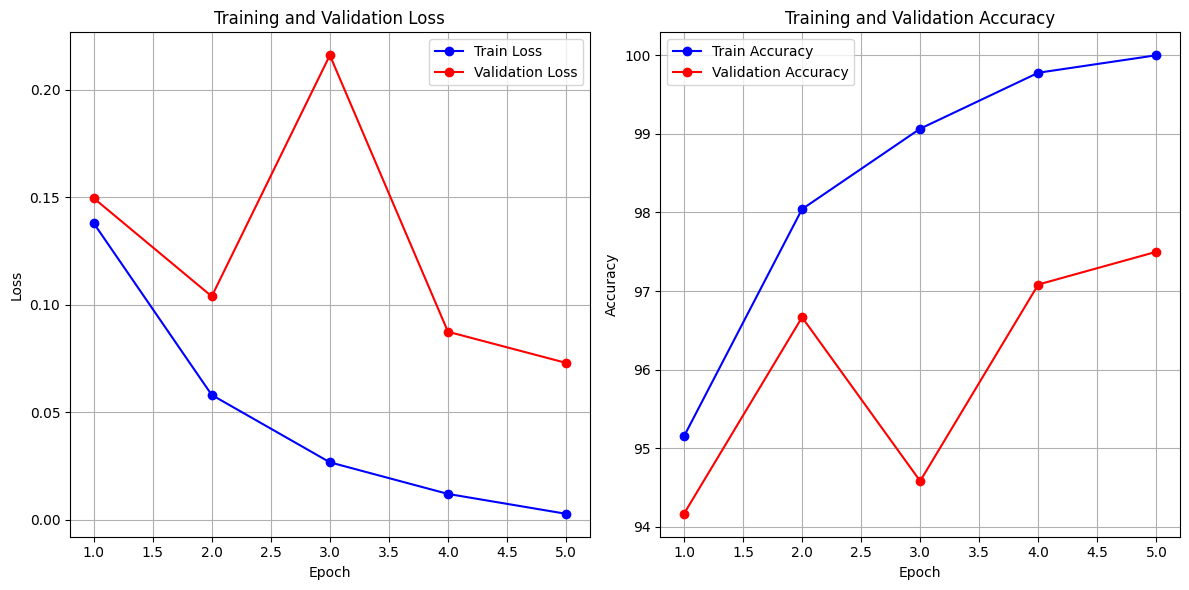

In [13]:
plot_from_history(Fsecondhistory)

In [23]:
df = pd.DataFrame(Fsecondhistory)
df.to_csv('training_history/second_training_historyv7.csv', index=False)


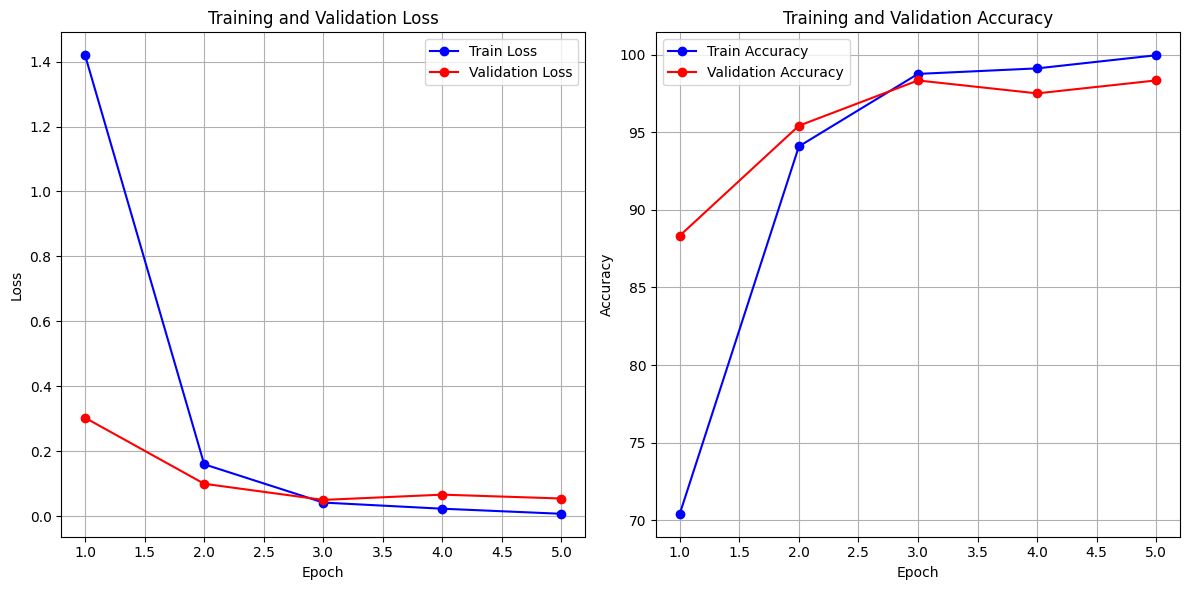

In [16]:

history_df = pd.read_csv('training_history/second_training_historyv7.csv')

Fsecondhistory = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}

plot_from_history(Fsecondhistory)

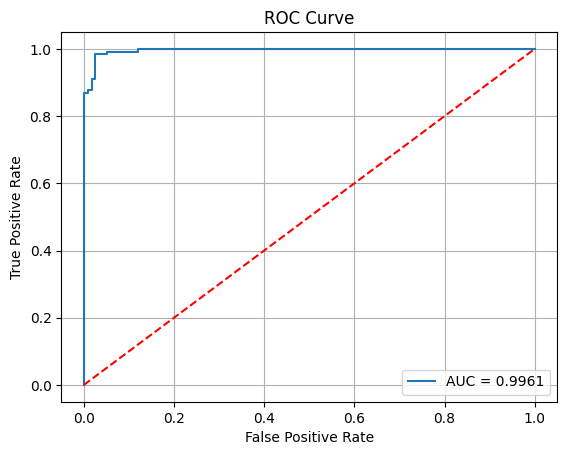

In [24]:
import pandas as pd

# Flatten data for CSV saving
Fsecondmetrics_flat = {
    "class_names": Fsecondmetrics["class_names"],
    "fpr": Fsecondmetrics["fpr"],
    "fnr": Fsecondmetrics["fnr"],
    "auc_roc": Fsecondmetrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in Fsecondmetrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in Fsecondmetrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in Fsecondmetrics["confusion_matrix"]]
}
plot_roc_curve(Fsecondmetrics_flat)


In [25]:

# # Save metrics to CSV
metrics_df = pd.DataFrame(Fsecondmetrics_flat)

metrics_df.to_csv('training_history/second_training_metricsv7.csv', index=False)


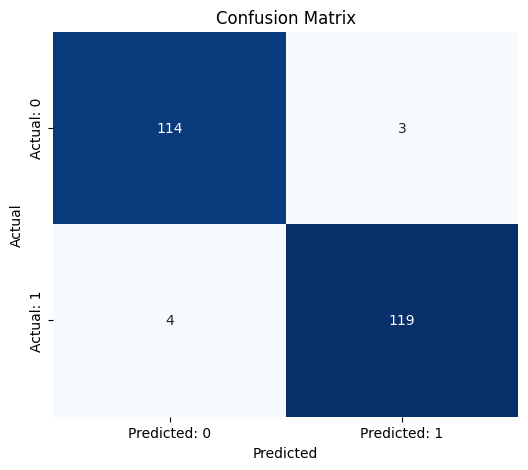

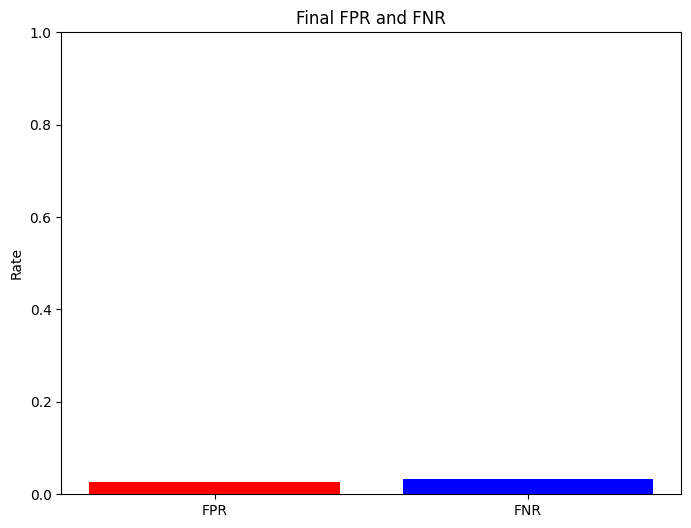

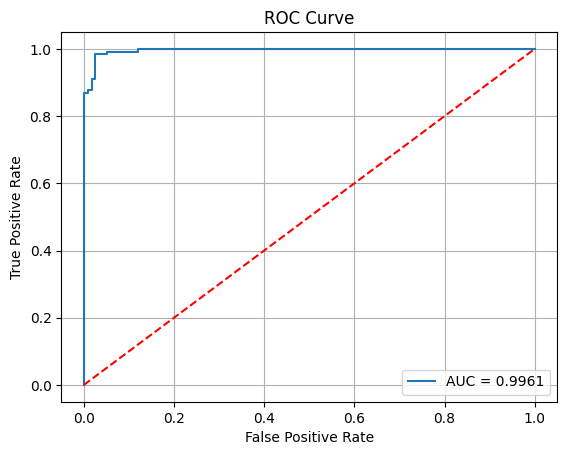

In [17]:


# Load the CSV file containing the final metrics
metrics_df = pd.read_csv('training_history/second_training_metricsv7.csv')

# Extract individual metrics
auc_score = metrics_df['auc_roc'][0]
fpr = metrics_df['fpr'][0]
fnr = metrics_df['fnr'][0]

# Extract confusion matrix (flattened form)
conf_matrix = list(map(int, metrics_df['confusion_matrix'][0].split(', ')))  # Convert string to list of integers
tn, fp, fn, tp = conf_matrix

# Extract ROC curve data (flattened form)
roc_fpr = list(map(float, metrics_df['roc_curve_fpr'][0].split(', ')))
roc_tpr = list(map(float, metrics_df['roc_curve_tpr'][0].split(', ')))
# Confusion Matrix heatmap
conf_matrix = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot FPR and FNR
plt.figure(figsize=(8, 6))
plt.bar(['FPR', 'FNR'], [fpr, fnr], color=['red', 'blue'])
plt.ylabel('Rate')
plt.title('Final FPR and FNR')
plt.ylim(0, 1)
plt.show()

plt.figure()
plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()


### Save Model


In [18]:
torch.save(model, "../Saved models/resnet_inception_fullmodel_croppedv7.pth")
scripted_model = torch.jit.script(model)  # Convert model to TorchScript
scripted_model.save("../Saved models/resnet_inception_fullmodel_croppedv7.pt")


### Import Model

In [19]:
from torchvision import transforms
from PIL import Image
import torch

import warnings
class_names = ['Appropriate', 'Inappropriate']

# Suppress specific UserWarning for InceptionV3
warnings.filterwarnings("ignore", message="Scripted Inception3 always returns Inception3 Tuple")

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fussionmodel = torch.load('Saved models/resnet_inception_fullmodel_cropped.pth')
# fussionmodel.to(device)
# fussionmodel.eval() 

fuse = torch.jit.load("../Saved models/resnet_inception_fullmodel_croppedv7.pt")
fuse.to(device)
fuse.eval()

# # Perform the forward pass during prediction
# with torch.no_grad():  # Disable gradient tracking during inference for efficiency
#     x_resnet = x_resnet.to(device)  # Make sure the input is on the correct device (CPU/GPU)
#     x_inception = x_inception.to(device)
#     output = model(x_resnet, x_inception)
# # Image preprocessing functions equivalent to TensorFlow preprocessing

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Inception normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_inception = Image.open(img_path).convert('RGB')

    # Apply transformations for ResNet and Inception
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0)  # Add batch dimension
    img_tensor_inception = inception_transform(img_inception).unsqueeze(0)
    
    return img_tensor_resnet, img_tensor_inception

def predict_image(img_path):
    img_tensor_resnet, img_tensor_inception = preprocess_image(img_path)
    img_tensor_resnet, img_tensor_inception = img_tensor_resnet.to(device), img_tensor_inception.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = fuse(img_tensor_resnet, img_tensor_inception)
        predicted_value = outputs.item()  # Extract scalar prediction

    # Return class name based on threshold
    predicted_class = class_names[int(predicted_value > 0.5)]
    return predicted_class

print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")

['Appropriate', 'Inappropriate']
Predicted Class for ./DARKNET/test.jpg: Appropriate
Predicted Class for ./DARKNET/test1.jpg: Appropriate
Predicted Class for ./DARKNET/test2.jpg: Inappropriate
Predicted Class for ./DARKNET/test3.jpg: Inappropriate
Predicted Class for ./DARKNET/test4.jpg: Inappropriate
Predicted Class for ./DARKNET/test5.jpg: Inappropriate
Predicted Class for ./DARKNET/test6.jpg: Inappropriate
Predicted Class for ./DARKNET/test7.jpg: Appropriate
Predicted Class for ./DARKNET/zeb.jpg: Appropriate


# RESNET X SVM MODEL


Directory found: ./train_800
Contents: ['Appropriate', 'Inappropriate']
Class Names: ['Appropriate', 'Inappropriate']
Appropriate class size: 802
Inappropriate class size: 804


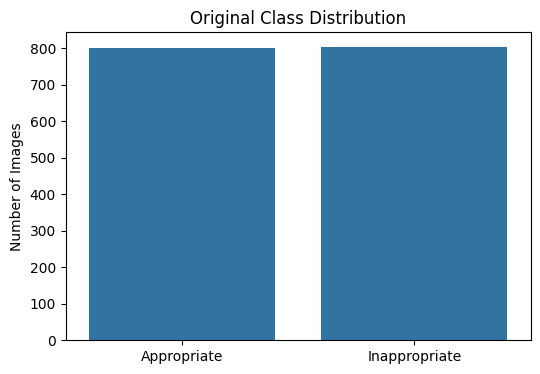

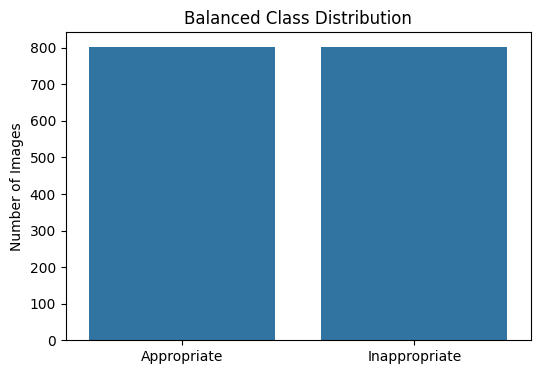

Augmented Training Dataset Size: 2244 (Includes Flipped Images)
Validation Dataset Size: 240
Test Dataset Size: 242


In [1]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torchvision.transforms import InterpolationMode
from PIL import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from torchvision.models import ResNet50_Weights
import os
import numpy as np
from tqdm import tqdm
import glob
import pandas as pd
from torch.utils.data import DataLoader, Dataset,  Subset
from torchvision.datasets import ImageFolder
import seaborn as sns
import random
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from Datapreprocess import AugmentedImageFolder_resnet, Applytransform_resnet
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import torch.optim as optim

# Dataset path


# Dataset path
dataset_path = "./train_800"
if not os.path.exists(dataset_path):
    print(f"Directory not found: {dataset_path}")
else:
    print(f"Directory found: {dataset_path}")
    print("Contents:", os.listdir(dataset_path))

# Define transformations
transform_visual = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load dataset with transformations
# dataset = ImageFolder(dataset_path, transform=transform)
# dataset_visual = ImageFolder(dataset_path, transform=transform_visual)

# Extract class names
# class_names = sorted(os.listdir(dataset_path))  # Ensure consistent label ordering
# class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
# print("Class Names:", class_names)

# # Separate images by class
# image_paths = []
# labels = []
# for class_name in class_names:
#     class_folder = os.path.join(dataset_path, class_name)
#     if os.path.isdir(class_folder):
#         for img_path in glob.glob(f"{class_folder}/*.jpg"):
#             image_paths.append(img_path)
#             labels.append(class_to_idx[class_name])

# print("Total images found:", len(image_paths))

# # Separate images by class for balancing
# appropriate_indices = [i for i, label in enumerate(labels) if label == 0]
# inappropriate_indices = [i for i, label in enumerate(labels) if label == 1]

# # Check class sizes
# print(f"Appropriate class size: {len(appropriate_indices)}")
# print(f"Inappropriate class size: {len(inappropriate_indices)}")

# # Plot original class distribution
# plt.figure(figsize=(6, 4))
# sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
# plt.title("Original Class Distribution")
# plt.ylabel("Number of Images")
# plt.show()

# # Balance the dataset by undersampling the larger class
# if len(appropriate_indices) > len(inappropriate_indices):
#     appropriate_indices = random.sample(appropriate_indices, len(inappropriate_indices))

# # Merge the balanced indices and shuffle
# balanced_indices = appropriate_indices + inappropriate_indices
# balanced_indices = shuffle(balanced_indices)


# # Sample and show images from both classes
# def show_images(indices, title, num_images=5):
#     fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
#     for i, idx in enumerate(random.sample(indices, num_images)):
#         img, label = dataset_visual[idx]
#         axes[i].imshow(img.permute(1, 2, 0))  # Convert to (H, W, C)
#         axes[i].set_title(class_names[label])
#         axes[i].axis("off")
#     plt.suptitle(title)
#     plt.show()

# # 🔹 **Display sample images**
# show_images(appropriate_indices, "Sample: Appropriate Content")
# show_images(inappropriate_indices, "Sample: Inappropriate Content")
# # Load balanced dataset
# balanced_image_paths = [image_paths[i] for i in balanced_indices]
# balanced_labels = [labels[i] for i in balanced_indices]

# images = []
# for img_path in tqdm(balanced_image_paths, desc="Loading balanced images"):
#     img = Image.open(img_path).convert("RGB")
#     img_tensor = transform(img)
#     images.append(img_tensor)

# images = torch.stack(images)
# labels = torch.tensor(balanced_labels)

#    transforms.Lambda(lambda img: transforms.functional.hflip(img)), 



# Load raw dataset without transformation
dataset_raw = ImageFolder(dataset_path)
class_names = dataset_raw.classes
class_to_idx = dataset_raw.class_to_idx
print("Class Names:", class_names)

# Extract class indices
labels = [label for _, label in dataset_raw.samples]
appropriate_indices = [i for i, label in enumerate(labels) if label == class_to_idx["Appropriate"]]
inappropriate_indices = [i for i, label in enumerate(labels) if label == class_to_idx["Inappropriate"]]


# Check class sizes
print(f"Appropriate class size: {len(appropriate_indices)}")
print(f"Inappropriate class size: {len(inappropriate_indices)}")

# Plot original class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Original Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# Balance dataset by undersampling the larger class
min_class_size = min(len(appropriate_indices), len(inappropriate_indices))
appropriate_indices = random.sample(appropriate_indices, min_class_size)
inappropriate_indices = random.sample(inappropriate_indices, min_class_size)

# Merge & shuffle indices
balanced_indices = appropriate_indices + inappropriate_indices
random.shuffle(balanced_indices)

# Plot balanced class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Balanced Class Distribution")
plt.ylabel("Number of Images")
plt.show()


# Define split sizes (70% train, 15% val, 15% test)
train_size = int(0.7 * len(balanced_indices))
val_size = int(0.15 * len(balanced_indices))
test_size = len(balanced_indices) - train_size - val_size

# Split indices
train_indices = balanced_indices[:train_size]
val_indices = balanced_indices[train_size:train_size + val_size]
test_indices = balanced_indices[train_size + val_size:]

# Create Subset datasets
dataset_train = Subset(dataset_raw, train_indices)
dataset_val = Subset(dataset_raw, val_indices)
dataset_test = Subset(dataset_raw, test_indices)

# Wrap in AugmentedImageFolder for flipping
dataset_train = AugmentedImageFolder_resnet(dataset_train)

# Apply transformations to val & test sets
dataset_val = Applytransform_resnet(dataset_val)
dataset_test = Applytransform_resnet(dataset_test)
# Create DataLoaders
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Augmented Training Dataset Size: {len(dataset_train)} (Includes Flipped Images)")
print(f"Validation Dataset Size: {len(dataset_val)}")
print(f"Test Dataset Size: {len(dataset_test)}")

# Load ResNet50 pre-trained model
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet.fc = nn.Identity()

for param in resnet.parameters():
    param.requires_grad = False

# for param in list(resnet.parameters())[-75:]:
#     param.requires_grad = True

# Move model and data to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)
# images = images.to(device)
class ResNet50FeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super(ResNet50FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Keep layers up to the last conv layer

    def forward(self, x):
        x = self.features(x)  # Extract features
        return x
    
# WORKS EXACTLY THE SAME WITH NN.IDENTITY IF nn.Sequential(*list(base_model.children())[:-1]) , gap will be retained
base_model_resnet = ResNet50FeatureExtractor(models.resnet50(weights=ResNet50_Weights.DEFAULT))
base_model_resnet.eval()
base_model_resnet = base_model_resnet.to(device)




In [ ]:
for imgs, labels in train_loader:
    print("Batch shape:", imgs.shape)
    break  # Print only once
for imgs, labels in val_loader:
    print("Batch shape:", imgs.shape)
    break  # Print only once
for imgs, labels in test_loader:
    print("Batch shape:", imgs.shape)
    break  # Print only once

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..1.8731157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..1.8731157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..1.9749122].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..1.9749122].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
C

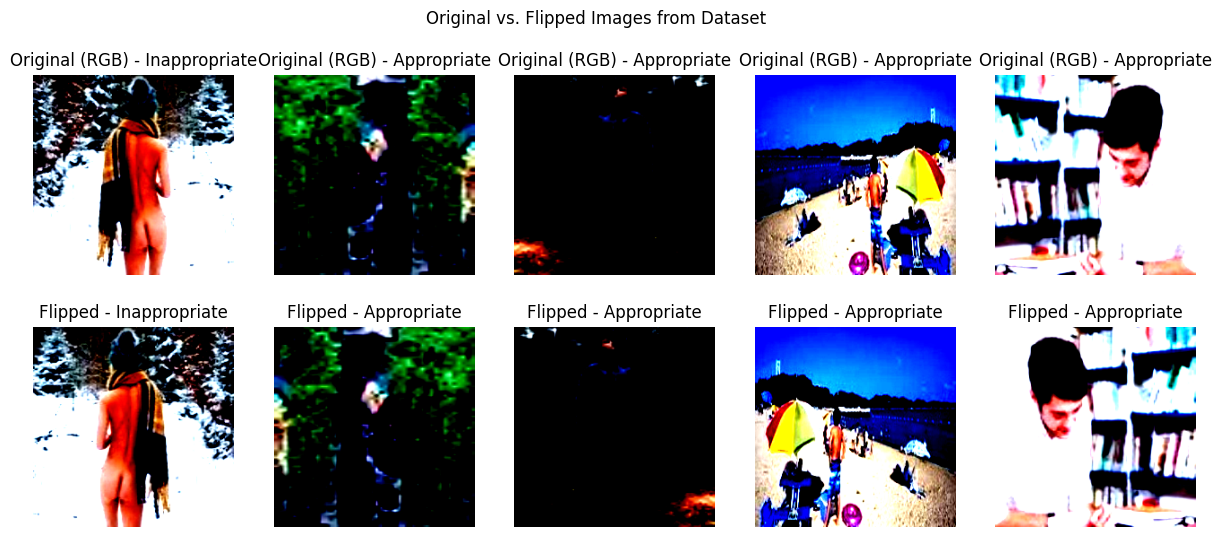

In [16]:
import matplotlib.pyplot as plt
import torch
import random
from PIL import Image
from torchvision import transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display original vs. augmented (flipped) images with mode check
def show_original_vs_augmented(dataset_train, dataset_raw, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        index = random.randint(0, len(dataset_train) // 2 - 1)  # Select from original images only
        original_idx = index * 2  # Original image index
        flipped_idx = original_idx + 1  # Flipped image index

        # Get original file path (before transformation)
        img_path, label_original = dataset_raw.samples[index]

        # Open original image with PIL
        img_pil = Image.open(img_path)
        mode_original = img_pil.mode  # Check mode

        # Load images from dataset_train (already transformed)
        img_original, label_original = dataset_train[original_idx]
        img_flipped, label_flipped = dataset_train[flipped_idx]

        # Convert tensors to numpy for display
        img_original_np = img_original.permute(1, 2, 0).numpy()
        img_flipped_np = img_flipped.permute(1, 2, 0).numpy()

        # Display original
        axes[0, i].imshow(img_original_np)
        axes[0, i].set_title(f"Original ({mode_original}) - {dataset_raw.classes[label_original]}")
        axes[0, i].axis("off")

        # Display flipped
        axes[1, i].imshow(img_flipped_np)
        axes[1, i].set_title(f"Flipped - {dataset_raw.classes[label_flipped]}")
        axes[1, i].axis("off")

    plt.suptitle("Original vs. Flipped Images from Dataset")
    plt.show()
    

# Show images using `dataset_train`
show_original_vs_augmented(dataset_train, dataset_raw)


## Extract features for train, test and val

In [2]:
def extract_features(dataloader, model, device):

    features = []
    labels_list = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, total=len(dataloader), desc="Extracting features"):
            imgs = imgs.to(device)  # Move batch to device
            batch_features = model(imgs).cpu().numpy()  # Extract features for batch
            features.extend(batch_features)  # Append batch features
            labels_list.extend(labels.numpy())  # Convert labels to list

    return np.array(features), np.array(labels_list)


In [3]:
X_train, y_train = extract_features(train_loader, resnet, device)


Extracting features: 100%|██████████| 71/71 [00:39<00:00,  1.78it/s]


In [4]:
X_val, y_val = extract_features(val_loader, resnet, device)


Extracting features: 100%|██████████| 8/8 [00:20<00:00,  2.51s/it]


In [5]:
X_test, y_test = extract_features(test_loader, resnet, device)

Extracting features: 100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


### NOT REUSABLE FOR EXTRACTION

In [14]:
features = []
labels_list = []
dataset = dataset_train  # Change this to dataset_val or dataset_test as needed

with torch.no_grad():
     for img, label in tqdm(dataset, total=len(dataset), desc="Extracting features"):
        img = img.unsqueeze(0).to(device)  # Add batch dimensionTransform and add batch dimension
        feature = resnet(img).squeeze().cpu().numpy()  # Extract and convert feature
        features.append(feature)
        labels_list.append(label)  # Store labels in a list

features = np.array(features)
labels = np.array(labels_list)  # Convert labels to numpy array


Extracting features: 100%|██████████| 124/124 [00:03<00:00, 39.89it/s]


In [6]:

# Split dataset
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
svm_classifier = svm.SVC(kernel='linear', C=1, probability=True, random_state=42)

# 1. Perform cross-validation (before final training)
cv_scores = cross_val_score(svm_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

# Train SVM Classifier
print("Training SVM classifier...")
svm_classifier.fit(X_train, y_train)



# Validate on validation set
y_pred_val = svm_classifier.predict(X_val)
print("Validation Classification Report:")
val_report = classification_report(y_val, y_pred_val, target_names=class_names)
print(val_report)
print(f"Accuracy Score: {accuracy_score(y_val, y_pred_val)}")

# Final evaluation on test set
y_pred_test = svm_classifier.predict(X_test)
print("Test Classification Report:")
report = classification_report(y_test, y_pred_test, target_names=class_names)
y_prob = svm_classifier.predict_proba(X_test)[:, 1]  # Now we use predict_proba()
print(report)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_test)}")






Cross-validation accuracy scores: [0.97772829 0.98886414 0.99331849 0.99331849 0.99330357]
Mean CV accuracy: 0.9893065940184537
Training SVM classifier...
Validation Classification Report:
               precision    recall  f1-score   support

  Appropriate       0.94      0.97      0.96       118
Inappropriate       0.97      0.94      0.96       122

     accuracy                           0.96       240
    macro avg       0.96      0.96      0.96       240
 weighted avg       0.96      0.96      0.96       240

Accuracy Score: 0.9583333333333334
Test Classification Report:
               precision    recall  f1-score   support

  Appropriate       0.98      0.98      0.98       122
Inappropriate       0.97      0.97      0.97       120

     accuracy                           0.98       242
    macro avg       0.98      0.98      0.98       242
 weighted avg       0.98      0.98      0.98       242

Accuracy Score: 0.9752066115702479


In [7]:

# Save classification report to a file
with open("./training_history/SVM_first_classification_reportv5.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracy_score(y_test, y_pred_test)}\n") 




In [8]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

def plot_confusion_matrix(y_test, y_pred, class_names):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def fromfile_plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
def plot_feature_importance(svm_classifier, feature_names):
    if hasattr(svm_classifier, "coef_"):
        importance = np.abs(svm_classifier.coef_).flatten()
        sorted_idx = np.argsort(importance)[::-1]
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(importance)), importance[sorted_idx], align="center")
        plt.xticks(range(len(importance)), np.array(feature_names)[sorted_idx], rotation=90)
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.title("Feature Importance in Linear SVM")
        plt.show()
    else:
        print("Feature importance is only available for linear SVMs.")


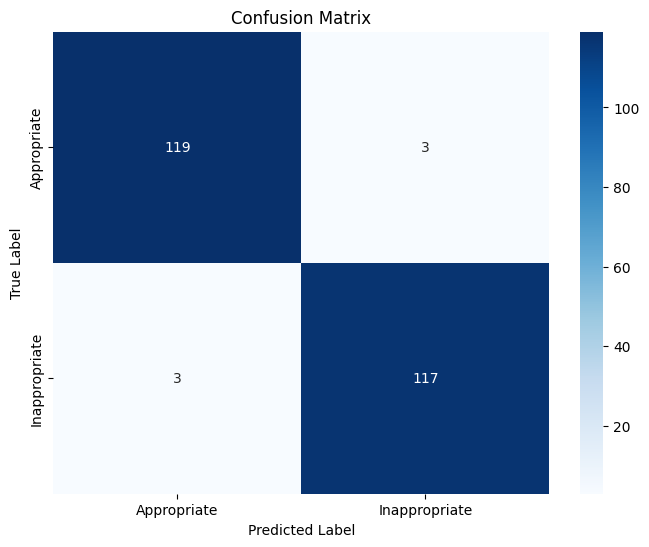

TN: 119, FP: 3, FN: 3, TP: 117


In [9]:
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    confusion_matrix, roc_curve
)
plot_confusion_matrix(y_test, y_pred_test, class_names)
# Extract TN, FP, FN, TP

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")  # Explicit print


False Positive Rate (FPR): 0.0246
False Negative Rate (FNR): 0.0250
AUC-ROC Score: 0.9980


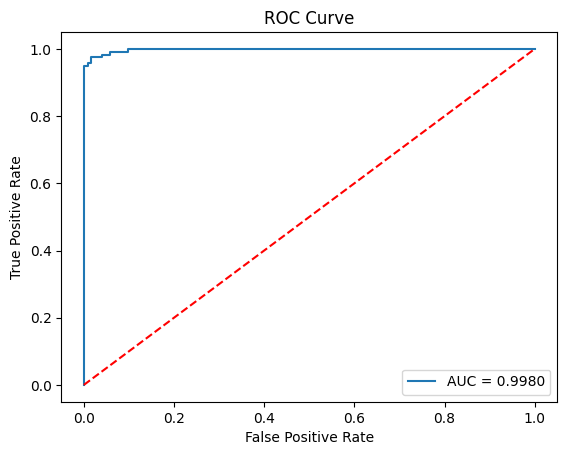

In [10]:

# Compute FPR and FNR
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

# Compute AUC-ROC using predict_proba()
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr_vals, tpr_vals, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### second training

In [11]:
class ResNet50BinaryClassifier(nn.Module):
    def __init__(self, feature_extractor):
        super(ResNet50BinaryClassifier, self).__init__()
        self.feature_extractor = feature_extractor  # ResNet backbone
        self.classifier = nn.Linear(2048, 1)  # 🔹 Single output neuron for logits

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)  
        return x  # 🔹 No sigmoid here (BCEWithLogitsLoss will handle it)

# Create model
model = ResNet50BinaryClassifier(resnet).to(device)
 
for param in resnet.layer4.parameters():  # Unfreezing layer4 (last block)
    param.requires_grad = True
for param in resnet.layer3.parameters():  # Unfreezing layer4 (last block)
    param.requires_grad = True
for param in model.classifier.parameters():  # ✅ Ensure classifier is trainable
    param.requires_grad = True
for name, param in resnet.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")



conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.0.conv3.weight: Frozen
layer1.0.bn3.weight: Frozen
layer1.0.bn3.bias: Frozen
layer1.0.downsample.0.weight: Frozen
layer1.0.downsample.1.weight: Frozen
layer1.0.downsample.1.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer1.1.conv3.weight: Frozen
layer1.1.bn3.weight: Frozen
layer1.1.bn3.bias: Frozen
layer1.2.conv1.weight: Frozen
layer1.2.bn1.weight: Frozen
layer1.2.bn1.bias: Frozen
layer1.2.conv2.weight: Frozen
layer1.2.bn2.weight: Frozen
layer1.2.bn2.bias: Frozen
layer1.2.conv3.weight: Frozen
layer1.2.bn3.weight: Frozen
layer1.2.bn3.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: F

In [3]:
import copy

initial_weights = copy.deepcopy(resnet.state_dict())  # Save a copy before training


In [ ]:
criterion = nn.BCEWithLogitsLoss()  # ✅ Use logits loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()  # Float labels needed

        optimizer.zero_grad()
        outputs = model(images).squeeze()  # Remove extra dimension
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0).float()  # ✅ Logits threshold at 0 (not 0.5 since no sigmoid in forward)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")


In [12]:

# Define loss function
criterion = nn.BCEWithLogitsLoss()  # ✅ Use logits loss

# Define optimizer (filtering requires_grad parameters)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0003)

# Define scheduler for learning rate decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00009)

# Training parameters
epochs = 5

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device).float()  # Ensure labels are float

        optimizer.zero_grad()
        outputs = model(images).squeeze()  # Remove extra dimension
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0).float()  # ✅ Logits threshold at 0 (not 0.5)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    # Validation step
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = (outputs > 0).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{epochs}:")
    print(f"Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
    print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%")

    # Adjust learning rate with scheduler
    print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
    scheduler.step()
    print(f"After Step Learning Rate: {scheduler.get_last_lr()[0]}\n")

print("Training complete.")

Epoch 1/5: 100%|██████████| 71/71 [00:33<00:00,  2.09it/s, accuracy=94.7, loss=0.00199]



Epoch 1/5:
Train Loss = 0.1398, Train Accuracy = 94.70%
Validation Loss = 0.1073, Validation Accuracy = 96.67%
Before Step Learning Rate: 0.0003
After Step Learning Rate: 0.00027994678440936943



Epoch 2/5: 100%|██████████| 71/71 [00:34<00:00,  2.07it/s, accuracy=98.7, loss=3.37]   



Epoch 2/5:
Train Loss = 0.0805, Train Accuracy = 98.71%
Validation Loss = 0.2627, Validation Accuracy = 92.92%
Before Step Learning Rate: 0.00027994678440936943
After Step Learning Rate: 0.00022744678440936945



Epoch 3/5: 100%|██████████| 71/71 [00:31<00:00,  2.25it/s, accuracy=97.1, loss=0.162]  



Epoch 3/5:
Train Loss = 0.0739, Train Accuracy = 97.10%
Validation Loss = 0.1227, Validation Accuracy = 95.42%
Before Step Learning Rate: 0.00022744678440936945
After Step Learning Rate: 0.00016255321559063049



Epoch 4/5: 100%|██████████| 71/71 [00:29<00:00,  2.41it/s, accuracy=99.3, loss=0.119]  



Epoch 4/5:
Train Loss = 0.0237, Train Accuracy = 99.29%
Validation Loss = 0.1137, Validation Accuracy = 95.83%
Before Step Learning Rate: 0.00016255321559063049
After Step Learning Rate: 0.00011005321559063052



Epoch 5/5: 100%|██████████| 71/71 [00:29<00:00,  2.42it/s, accuracy=99.8, loss=0.0113]  



Epoch 5/5:
Train Loss = 0.0104, Train Accuracy = 99.82%
Validation Loss = 0.0909, Validation Accuracy = 97.08%
Before Step Learning Rate: 0.00011005321559063052
After Step Learning Rate: 9e-05

Training complete.


In [5]:
for name, param in resnet.named_parameters():
    if not torch.equal(param, initial_weights[name]):
        print(f"{name} was updated ✅")
    else:
        print(f"{name} is unchanged ❌ (still frozen)")


conv1.weight is unchanged ❌ (still frozen)
bn1.weight is unchanged ❌ (still frozen)
bn1.bias is unchanged ❌ (still frozen)
layer1.0.conv1.weight is unchanged ❌ (still frozen)
layer1.0.bn1.weight is unchanged ❌ (still frozen)
layer1.0.bn1.bias is unchanged ❌ (still frozen)
layer1.0.conv2.weight is unchanged ❌ (still frozen)
layer1.0.bn2.weight is unchanged ❌ (still frozen)
layer1.0.bn2.bias is unchanged ❌ (still frozen)
layer1.0.conv3.weight is unchanged ❌ (still frozen)
layer1.0.bn3.weight is unchanged ❌ (still frozen)
layer1.0.bn3.bias is unchanged ❌ (still frozen)
layer1.0.downsample.0.weight is unchanged ❌ (still frozen)
layer1.0.downsample.1.weight is unchanged ❌ (still frozen)
layer1.0.downsample.1.bias is unchanged ❌ (still frozen)
layer1.1.conv1.weight is unchanged ❌ (still frozen)
layer1.1.bn1.weight is unchanged ❌ (still frozen)
layer1.1.bn1.bias is unchanged ❌ (still frozen)
layer1.1.conv2.weight is unchanged ❌ (still frozen)
layer1.1.bn2.weight is unchanged ❌ (still frozen)


In [13]:
for name, param in resnet.named_parameters():
    if "layer4" in name:
        diff = (param - initial_weights[name]).abs().sum().item()
        print(f"{name}: Total weight change = {diff:.6f}")


layer4.0.conv1.weight: Total weight change = 263.298676
layer4.0.bn1.weight: Total weight change = 0.275847
layer4.0.bn1.bias: Total weight change = 0.270497
layer4.0.conv2.weight: Total weight change = 1164.388672
layer4.0.bn2.weight: Total weight change = 0.290680
layer4.0.bn2.bias: Total weight change = 0.280552
layer4.0.conv3.weight: Total weight change = 572.172241
layer4.0.bn3.weight: Total weight change = 1.096257
layer4.0.bn3.bias: Total weight change = 1.059013
layer4.0.downsample.0.weight: Total weight change = 1094.823608
layer4.0.downsample.1.weight: Total weight change = 1.118313
layer4.0.downsample.1.bias: Total weight change = 1.059013
layer4.1.conv1.weight: Total weight change = 539.087402
layer4.1.bn1.weight: Total weight change = 0.282910
layer4.1.bn1.bias: Total weight change = 0.279750
layer4.1.conv2.weight: Total weight change = 1199.836670
layer4.1.bn2.weight: Total weight change = 0.305651
layer4.1.bn2.bias: Total weight change = 0.310011
layer4.1.conv3.weight: T

In [13]:

X_train2, y_train = extract_features(train_loader, resnet, device)


Extracting features: 100%|██████████| 71/71 [00:26<00:00,  2.71it/s]


In [14]:
X_val2, y_val = extract_features(val_loader, resnet, device)


Extracting features: 100%|██████████| 8/8 [00:16<00:00,  2.12s/it]


In [15]:
X_test2, y_test = extract_features(test_loader, resnet, device)

Extracting features: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it]


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# 🔹 Standardize CNN features (important for SVM!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train2)
X_test_scaled = scaler.transform(X_test2)
X_val_scaled = scaler.transform(X_val2)

# # 🔹 Define parameter grid for C values
# param_grid = {'C': [0.01, 0.1, 1, 10]}

# # 🔹 Perform Grid Search
# grid_search = GridSearchCV(svm.SVC(kernel='linear', probability=True, random_state=42), param_grid, cv=5, scoring='accuracy', verbose=2)
# grid_search.fit(X_train_scaled, y_train)

# # 🔹 Get best hyperparameters
# best_C = grid_search.best_params_['C']
# print(f"Best C: {best_C}")


svm_classifier = svm.SVC(kernel='linear', C=0.01, probability=True, random_state=42)




cv_scores = cross_val_score(svm_classifier, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

# 🔹 Train final SVM with best C
svm_classifier.fit(X_train_scaled, y_train)


# Validate on validation set
y_pred_val = svm_classifier.predict(X_val_scaled)
print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=class_names))
print(f"Accuracy Score: {accuracy_score(y_val, y_pred_val)}")


# 🔹 Evaluate
y_pred = svm_classifier.predict(X_test_scaled)
y_prob = svm_classifier.predict_proba(X_test_scaled)[:, 1]

# print("Classification Report:")
# print(classification_report(y_test, y_pred, target_names=class_names))
# print("Accuracy Score:", accuracy_score(y_test, y_pred))

print("Classification Report:")
# Generate classification report
report = classification_report(y_test, y_pred, target_names=class_names)

# Save classification report to a file
with open("SVM_second_classification_reportv5.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracy_score(y_test, y_pred)}\n") 

print(report)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")


Cross-validation accuracy scores: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.0
Validation Classification Report:
               precision    recall  f1-score   support

  Appropriate       0.97      0.97      0.97       118
Inappropriate       0.97      0.98      0.97       122

     accuracy                           0.97       240
    macro avg       0.97      0.97      0.97       240
 weighted avg       0.97      0.97      0.97       240

Accuracy Score: 0.9708333333333333
Classification Report:
               precision    recall  f1-score   support

  Appropriate       0.97      0.96      0.97       122
Inappropriate       0.96      0.97      0.97       120

     accuracy                           0.97       242
    macro avg       0.97      0.97      0.97       242
 weighted avg       0.97      0.97      0.97       242

Accuracy Score: 0.9669421487603306


In [ ]:
with open("HyperparamTuningSVMV4.txt", "r") as file:
    report = file.read()

print(report)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .............................................C=0.01; total time= 5.9min
[CV] END .............................................C=0.01; total time= 5.0min
[CV] END .............................................C=0.01; total time= 4.9min
[CV] END .............................................C=0.01; total time= 5.0min
[CV] END .............................................C=0.01; total time= 4.8min
[CV] END ..............................................C=0.1; total time= 6.1min
[CV] END ..............................................C=0.1; total time= 6.4min
[CV] END ..............................................C=0.1; total time= 6.4min
[CV] END ..............................................C=0.1; total time= 6.3min
[CV] END ..............................................C=0.1; total time= 5.8min
[CV] END ................................................C=1; total time= 6.0min
[CV] END ........................................

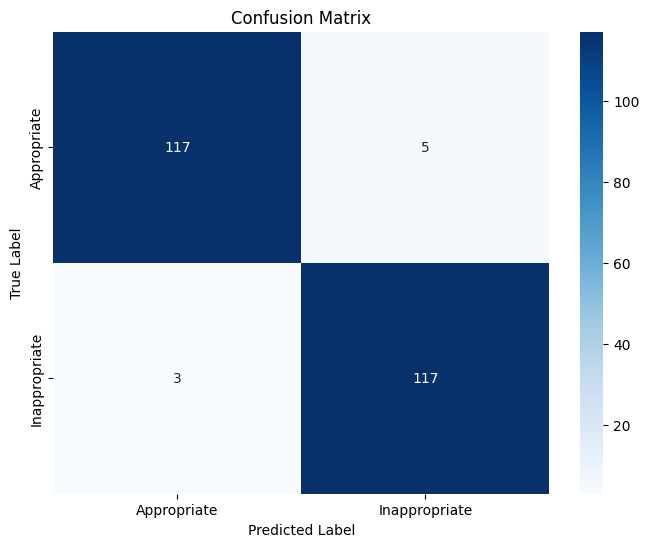

TN: 117, FP: 5, FN: 3, TP: 117


In [17]:
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    confusion_matrix, roc_curve
)
plot_confusion_matrix(y_test, y_pred, class_names)
# Extract TN, FP, FN, TP

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")  # Explicit print


False Positive Rate (FPR): 0.0396
False Negative Rate (FNR): 0.0571
AUC-ROC Score: 0.9905


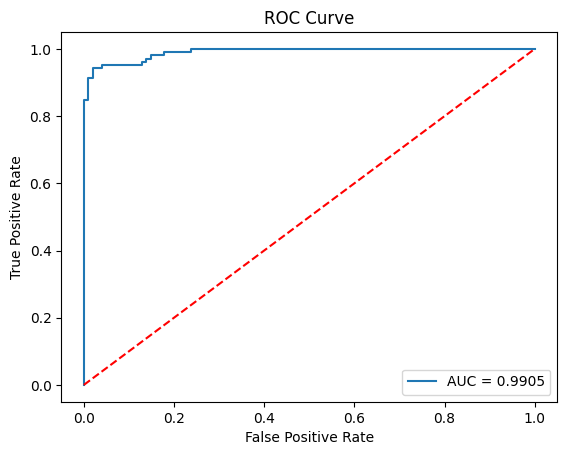

In [123]:

# Compute FPR and FNR
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

# Compute AUC-ROC using predict_proba()
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr_vals, tpr_vals, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### save training results


Metrics saved successfully.


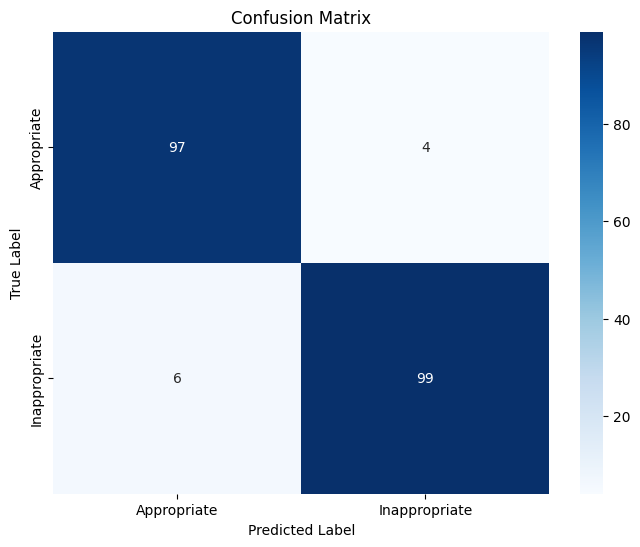

Accuracy: 0.9515
False Positive Rate (FPR): 0.0396
False Negative Rate (FNR): 0.0571
AUC-ROC Score: 0.9905


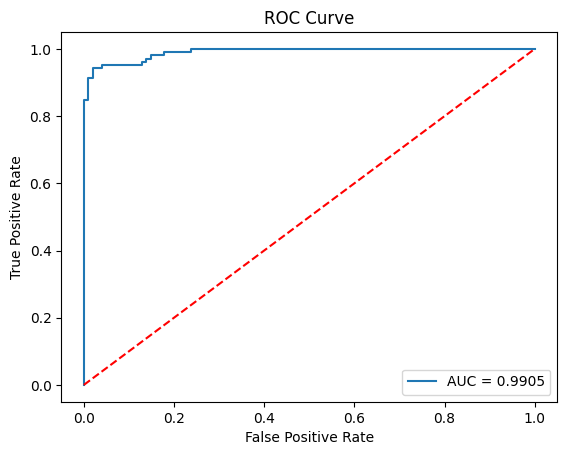

In [125]:
import pickle

metrics = {
    "class_names": class_names,
    "confusion_matrix": confusion_matrix(y_test, y_pred),
    "accuracy": accuracy_score(y_test, y_pred),
    "fpr": fpr,
    "fnr": fnr,
    "auc_roc": auc_score,
    "roc_curve": (fpr_vals, tpr_vals)  # Save ROC data for later plotting
}

# Save as a NumPy file
np.savez("training_history/second_svm_metricsv5.npz", **metrics)

# Save using Pickle (optional, for structured data)
# with open("svm_metrics.pkl", "wb") as f:
#     pickle.dump(metrics, f)

print("Metrics saved successfully.")
# Load metrics from NumPy file
loaded_data = np.load("training_history/second_svm_metricsv5.npz", allow_pickle=True)

# Extract metrics
conf_matrix = loaded_data["confusion_matrix"]
accuracy = loaded_data["accuracy"]
fpr = loaded_data["fpr"]
fnr = loaded_data["fnr"]
auc_score = loaded_data["auc_roc"]
fpr_vals, tpr_vals = loaded_data["roc_curve"]


# Plot the confusion matrix
fromfile_plot_confusion_matrix(conf_matrix, class_names)
print(f"Accuracy: {accuracy:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"AUC-ROC Score: {auc_score:.4f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Save RESNET X SVM

In [18]:
torch.save(resnet, "../Saved models/svm/fullresnetextractorv5.pth")

import joblib

svm_save_path = '../Saved models/svm'
svm_model_path = os.path.join(svm_save_path, 'fulltorch_svmv5.pkl')
joblib.dump(svm_classifier, svm_model_path)

['../Saved models/svm\\fulltorch_svmv5.pkl']

### Import Model

In [19]:
import os
import joblib
import torch
from torchvision import transforms
from PIL import Image

class_names = ['Appropriate', 'Inappropriate']

# Load the ResNet feature extractor
load_ex = torch.load('../Saved models/svm/fullresnetextractorv5.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_ex.to(device)
print("Feature extractor loaded.")

# Load the SVM model
svm_model_path = os.path.join('../Saved models/svm', 'fulltorch_svmv5.pkl')
load_svm = joblib.load(svm_model_path)
print("SVM classifier loaded.")
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0).to(device)

 
    
    return img_tensor_resnet

def predict_image(img_path):
    """
    Predict the class of an image using the saved ResNet-based feature extractor and SVM classifier.

    Args:
        img_path (str): Path to the image file.

    Returns:
        str: Predicted class name.
    """
    img = Image.open(img_path).convert("RGB")
    img_tensor = resnet_transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    load_ex.eval()  # Ensure the model is in evaluation mode
    
    with torch.no_grad():
        feature_map = load_ex(img_tensor)  
        flattened_features = feature_map.squeeze().cpu().numpy().reshape(1, -1)  
    prediction = load_svm.predict(flattened_features)  # Predict using the trained SVM classifier
    return class_names[prediction[0]]


print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")

C:\Users\user\AppData\Local\Temp\ipykernel_1628\1762208131.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_ex = torch.load('../Saved models/svm/fullresnetextractor

Feature extractor loaded.
SVM classifier loaded.
['Appropriate', 'Inappropriate']
Predicted Class for ./DARKNET/test.jpg: Appropriate
Predicted Class for ./DARKNET/test1.jpg: Appropriate
Predicted Class for ./DARKNET/test2.jpg: Inappropriate
Predicted Class for ./DARKNET/test3.jpg: Inappropriate
Predicted Class for ./DARKNET/test4.jpg: Inappropriate
Predicted Class for ./DARKNET/test5.jpg: Inappropriate
Predicted Class for ./DARKNET/test6.jpg: Inappropriate
Predicted Class for ./DARKNET/test7.jpg: Appropriate
Predicted Class for ./DARKNET/zeb.jpg: Inappropriate
